In [1]:
import sys
import os
%load_ext autoreload
%autoreload 2


sys.path.append('../')
os.chdir('../')

# Preparation

## Operation

In [2]:
import time
import math
import pickle
from contextlib import nullcontext

import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group


# from model import GPTConfig, GPT
from pe_info.model_nope import GPTConfig as GPTConfig_nope, GPT as GPT_nope
from main_utils import *

# -----------------------------------------------------------------------------
# default config values designed to train a gpt2 (124M) on OpenWebText
# I/O
out_dir = 'out'
resume_dir = None
resume_iter = False # if True, resume from saved iter_num, otherwise resume from iter_num 0
eval_interval = 2000
log_interval = 1
eval_iters = 200
eval_only = False # if True, script exits right after the first eval
always_save_checkpoint = True # if True, always save a checkpoint after each eval
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
# wandb logging
wandb_entity = 'ssdd'
wandb_log = True # disabled by default
wandb_project = 'owt'
wandb_run_name = 'gpt2' # 'run' + str(time.time())
exp_name = 'default_exp_name'
# data
train_data_path = 'train_3digit_10000.txt'
gradient_accumulation_steps = 1 # used to simulate larger batch sizes
test_batch_size = 128
batch_size = 12 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 1024
val_data_path = 'val.bin'
multi_digit = False
num_digit = 5
binary = False
# using two data - data1 = text / data2 = addition
train_both = False # use seperate text/add data for train/val (get_batch uses this to sample from two differernt datasets)
data_ratio = 0.2 # ratio of data_path2 compared with data_path1
train_data_path2 = 'train_addition.bin' # only used when train_both = True
val_data_path2 = 'val_addition.bin'
# evaluation
eval_text = False # if True get perplexity using eval_text_data_path
eval_text_data_path = None # directory to text data (.bin file) - ex. 'data/shakespeare_add_ar_mixed/val_text.bin' 
eval_addition = False # if True compute test accuracy of "a+b="
start = "FILE:data/bal/test_10000.txt"
eval_addition_ar = False
start_ar = None
eval_other = False # use this to evaluate other operations (ex. train on operator '-' but evaluate on other_operator '+')
start_other = None
other_operator = '+'
eval_addition_train = False
start_train = None
reverse_ab = False
reverse_c = False
zero_pad = False
algo_reason = False
add_space = False
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
bias = False # do we use bias inside LayerNorm and Linear layers?
ckpt_path_name = 'ckpt.pt'
save_final = True
# adamw optimizer
learning_rate = 6e-4 # max learning rate
max_iters = 600000 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
min_lr = None # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster
use_flash = True
data_type='text'
dataset = 'bal'
operator = '+' # can be '+', '-', '*', 'sin', 'sqrt'
data_shuffle = True
# data_format = 'algo_reasoning' # 'plain' or 'reverse' or 'algo_reasoning'
data_format = 'plain' # 'plain' or 'reverse' or 'algo_reasoning'

vocabulary = 'all_ascii_chars' # can be 'all_ascii_chars' or 'numbers_only' or 'custom_input_data'
meta_path_specified = False # use saved meta_file (False if data_type='text')
eps = 0
tokenizer = 'char' # by default, use char level tokenizer. but for pretrained models, use openai tokenizer eg: 'gpt2'

simple=False
random_A=False
random_C=False

use_lora = False # use lora (from minLoRA)
print_interval = 2  # if we're using gpt-2 model, I want to see it prompted on text

general_seed = 1337
# general_seed = 1227
resume_metric_from_best = True
use_pe = 'original'
use_residual = True
no_att_residual = False
no_mlp_residual = False
layerwise_pe = False
permute = False
not_causal = False

causal_training=True


config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str, type(None)))]
exec(open('./pe_info/config2_pe/modp/jason_train_addition_bal.py').read()) # overrides from command line or config file
# exec(open('./pe_info/config2_pe/addition/reverse/jason_train_addition_bal.py').read()) # overrides from command line or config file

config = {k: globals()[k] for k in config_keys} # will be useful for logging

In [3]:
print(causal_training)
causal_training = False
eval_addition_train

True


True

In [4]:
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# poor man's data loader
if data_type == 'binary':
    data_dir = os.path.join('data', dataset)
    train_data = np.memmap(os.path.join(data_dir, train_data_path), dtype=np.uint16, mode='r')
    val_data = np.memmap(os.path.join(data_dir, val_data_path), dtype=np.uint16, mode='r')
    if train_both:
        train_data2 = np.memmap(os.path.join(data_dir, train_data_path2), dtype=np.uint16, mode='r')
        val_data2 = np.memmap(os.path.join(data_dir, val_data_path2), dtype=np.uint16, mode='r')
    if eval_text:
        if eval_text_data_path is None:
            print('eval_text_data_path is None!!! No binary file to evaluate perplexity on.') 
        eval_text_data = np.memmap(eval_text_data_path, dtype=np.uint16, mode='r')
    # test_data_str = None # test_data for addition testing will be handled with "start"
    meta_path = None
else:
    # check for data_format
    if data_type == 'text':
        if ('reverse' in data_format and not reverse_c) or (reverse_c and 'reverse' not in data_format):
            raise ValueError('reverse_c must be True for data_format == "reverse"')
        elif (data_format == 'algo_reasoning' and not algo_reason) or (algo_reason and data_format != 'algo_reasoning'):
            raise ValueError('algo_reason must be True for data_format == "algo_reasoning"')
    meta_path_specified = False

    data_dir = os.path.join('data', dataset)
    train_data_path = os.path.join(data_dir, train_data_path)
    # val_data = os.path.join(data_dir, val_data_path)
    train_data_list = get_data_list(train_data_path, operator=operator) # a list of (x, y, op)
    val_data_list = get_data_list(filename=None, operator=operator) # get_data_list(val_data, operator='+')
    train_data_str = generate_data_str(train_data_list, operator=operator, format=data_format, train=True, shuffle=data_shuffle, add_space=add_space, simple=simple, random_A=random_A, random_C=random_C)
    val_data_str = generate_data_str(val_data_list, operator=operator, format=data_format, train=True, shuffle=data_shuffle, add_space=add_space, simple=simple, random_A=random_A, random_C=random_C)
    meta, meta_path, data_encoder, data_decoder = create_meta_file(vocabulary=vocabulary, input_data_str=train_data_str, tokenizer=tokenizer)
    meta_vocab_size = meta['vocab_size']
    train_data = data_encoder(train_data_str)
    val_data = data_encoder(val_data_str)
    if eval_addition_train and start_train is None:
        # specify the start_train to be our train data file
        start_train = f"FILE:{train_data_path}"
        
    if train_both:
        # This is for the case where we use two different datasets for training
        # we sample from both with a specified ratio - data_ratio
        # TODO: let's leave this here for now.
        train_data2 = np.memmap(os.path.join(data_dir, train_data_path2), dtype=np.uint16, mode='r')
        val_data2 = np.memmap(os.path.join(data_dir, val_data_path2), dtype=np.uint16, mode='r')
    
    if eval_text:
        # eval_text_data = np.memmap(eval_text_data_path, dtype=np.uint16, mode='r')
        text_data_list = get_data_list(eval_text_data_path, operator='text')
        text_data_str = generate_data_str(text_data_list, operator='text', format=data_format, train=False, shuffle=False)
        eval_text_data = data_encoder(text_data_str)


    

Creating meta file for all reasonable characters...
all the unique characters: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
vocab size: 96
data has 140,000 tokens
data has 14,000 tokens


In [5]:
from numpy import block


space_token = data_encoder(' ')[0]
switch_line_token = data_encoder('\n')[0]
equal_token = data_encoder('=')[0]
dollar_token = data_encoder('$')[0]
# non_causal_fix_length = 15
# non_causal_fix_length = 27
answer_length = 1
# def get_batch(split):
#         attn_mask = None
#         data = train_data if split == 'train' else val_data
#         if train_both:
#             data2 = train_data2 if split == 'train' else val_data2
#             batch_size2 = int(batch_size*data_ratio)
#             ix = torch.randint(len(data) - block_size, (batch_size-batch_size2,))
#             ix2 = torch.randint(len(data2) - block_size, (batch_size2,))
#         else:
#             if causal_training:
#                 ix = torch.randint(len(data) - block_size, (batch_size,))
#             else:
#                 split_points = np.where(data==(switch_line_token))[0]
#                 answer_split_points = np.where(data==(equal_token))[0]
#                 answer_length_list = split_points - answer_split_points - 1
#                 split_points = split_points + 1 # i should have had this
#                 split_points = np.hstack([np.array([0]), split_points.flatten()])

#                 sample_length_list = np.diff(split_points)
#                 start_points = split_points[:-1]

#                 randidx = np.random.permutation(len(start_points))[:batch_size]
#                 ix = start_points[randidx]
#                 sample_length_list = sample_length_list[randidx]
#                 answer_length_list = answer_length_list[randidx]

#         if causal_training:
#             x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
#             y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
#         else:
#             remove_dollar_count = 1 if dollar_token in data else 0
#             # cur_answer_length_list = np.random.randint(1+remove_dollar_count, answer_length_list+1) + 1
#             x = []
#             y = []
#             picked_i = []
#             picked_len = []
#             for i in range(len(ix)):
#                 for j in range(1+remove_dollar_count+1, answer_length_list[i]+2):
#                     x.append(data[ix[i]:ix[i]+sample_length_list[i]-j].astype(np.int64))
#                     y.append(data[ix[i]+sample_length_list[i]-j:ix[i]+1+sample_length_list[i]-j].astype(np.int64))
#                     picked_i.append(i)
#                     picked_len.append(j)
#                     if len(x) == batch_size:
#                         break
                    
#                 if len(x) == batch_size:
#                     break
#             # x = [data[ix[i]:ix[i]+sample_length_list[i]-cur_answer_length_list[i]].astype(np.int64) for i in range(len(ix))]
#             x_len = [len(x[i]) for i in range(len(x))]
#             pad_to_length = max(x_len)
#             min_length = min(x_len)
#             # only do padding when the length is not equal
#             if pad_to_length > min_length: 
#                 x = np.vstack([np.pad(x[i], (pad_to_length-len(x[i]), 0), mode='constant', constant_values=space_token) for i in range(len(x))])
#                 attn_mask = np.ones_like(x)
#                 # mask out the paddings
#                 attn_mask[x==space_token] = 0
#                 attn_mask = attn_mask[..., None]
#                 attn_mask = attn_mask @ attn_mask.transpose(0, 2, 1)
#                 attn_mask = attn_mask.astype(bool)
#                 if (attn_mask==1).all():
#                     attn_mask = None
#                 else:
#                     attn_mask = torch.from_numpy(attn_mask)
#             x = torch.from_numpy(x)
#             # predict the next digit
#             # y = torch.stack([torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]+1+sample_length_list[i]-cur_answer_length_list[i]]).astype(np.int64)) for i in range(len(ix))])
#             y = torch.from_numpy(np.array(y))
#         if train_both:
#             x2 = torch.stack([torch.from_numpy((data2[i:i+block_size]).astype(np.int64)) for i in ix2])
#             y2 = torch.stack([torch.from_numpy((data2[i+1:i+1+block_size]).astype(np.int64)) for i in ix2])
#             x = torch.cat([x,x2])
#             y = torch.cat([y,y2])    

#         if device_type == 'cuda':
#             # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
#             x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
#             if attn_mask is not None:
#                 attn_mask = attn_mask.pin_memory().to(device, non_blocking=True)
#         else:
#             x, y = x.to(device), y.to(device)
#             if attn_mask is not None:
#                 attn_mask = attn_mask.to(device)
        
#         # attn_mask = None
#         return x, y, attn_mask

# split= "train"

# def get_batch(split, autoregressive_training=False):
#         attn_mask = None
#         w = None
#         data = train_data if split == 'train' else val_data
#         if train_both:
#             data2 = train_data2 if split == 'train' else val_data2
#             batch_size2 = int(batch_size*data_ratio)
#             ix = torch.randint(len(data) - block_size, (batch_size-batch_size2,))
#             ix2 = torch.randint(len(data2) - block_size, (batch_size2,))
#         else:
#             if causal_training:
#                 ix = torch.randint(len(data) - block_size, (batch_size,))
#             else:
#                 split_points = np.where(data==(switch_line_token))[0]
#                 answer_split_points = np.where(data==(equal_token))[0]
#                 answer_length_list = split_points - answer_split_points - 1
#                 split_points = split_points + 1 # i should have had this
#                 split_points = np.hstack([np.array([0]), split_points.flatten()])

#                 sample_length_list = np.diff(split_points)
#                 start_points = split_points[:-1]

#                 # valid_choices = np.where(start_points>block_size)[0]
#                 # start_points = start_points[valid_choices]
#                 # sample_length_list = sample_length_list[valid_choices]

#                 randidx = np.random.permutation(len(start_points))[:batch_size]
#                 ix = start_points[randidx]
#                 sample_length_list = sample_length_list[randidx]
#                 answer_length_list = answer_length_list[randidx]

#         if causal_training:
#             x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
#             y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
#         else:
#             # remove_dollar_count = 1 if dollar_token in data else 0
#             # if not autoregressive_training:
#             #     cur_answer_length_list = np.random.randint(1+remove_dollar_count, answer_length_list+1) + 1
#             # else:
#             #     cur_answer_length_list = answer_length_list + 1
#             # x = [data[ix[i]:ix[i]+sample_length_list[i]-cur_answer_length_list[i]].astype(np.int64) for i in range(len(ix))]
#             # x_len = [len(x[i]) for i in range(len(x))]
#             # pad_to_length = max(x_len)
#             # min_length = min(x_len)
#             # # only do padding when the length is not equal
#             # if pad_to_length > min_length: 
#             #     x = np.vstack([np.pad(x[i], (pad_to_length-len(x[i]), 0), mode='constant', constant_values=space_token) for i in range(len(x))])
#             #     attn_mask = np.ones_like(x)
#             #     # mask out the paddings
#             #     attn_mask[x==space_token] = 0
#             #     attn_mask = attn_mask[..., None]
#             #     attn_mask = attn_mask @ attn_mask.transpose(0, 2, 1)
#             #     attn_mask = attn_mask.astype(bool)
#             #     if (attn_mask==1).all():
#             #         attn_mask = None
#             #     else:
#             #         attn_mask = torch.from_numpy(attn_mask)
#             # else:
#             #     x = np.vstack(x)
#             #     attn_mask = None
            
#             # x = torch.from_numpy(x)
#             # # predict the next digit
#             # if not autoregressive_training:
#             #     y = torch.stack([torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]+1+sample_length_list[i]-cur_answer_length_list[i]]).astype(np.int64)) for i in range(len(ix))])
#             # else:
#             #     y = [torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]-1+sample_length_list[i]]).astype(np.int64)) for i in range(len(ix))]
#             #     max_len_y = max([len(y[i]) for i in range(len(y))])
#             #     y = np.vstack([np.pad(y[i], (0, max_len_y-len(y[i])+pad_to_length-x_len[i]), mode='constant', constant_values=space_token) for i in range(len(y))])
#             #     y = torch.from_numpy(y)
#             #     w = torch.ones_like(y)
#             #     w[y==space_token] = 0
#             x = torch.stack([torch.from_numpy((data[i:i+block_size//4]).astype(np.int64)) for i in ix])
#             y = torch.stack([torch.from_numpy((data[i+block_size//4:i+5+block_size//4]).astype(np.int64)) for i in ix])
#             w = torch.ones_like(y)

#         if train_both:
#             x2 = torch.stack([torch.from_numpy((data2[i:i+block_size]).astype(np.int64)) for i in ix2])
#             y2 = torch.stack([torch.from_numpy((data2[i+1:i+1+block_size]).astype(np.int64)) for i in ix2])
#             x = torch.cat([x,x2])
#             y = torch.cat([y,y2])    

#         if device_type == 'cuda':
#             # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
#             x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
#             if w is not None:
#                 w = w.pin_memory().to(device, non_blocking=True)    
#             if attn_mask is not None:
#                 attn_mask = attn_mask.pin_memory().to(device, non_blocking=True)
#         else:
#             x, y = x.to(device), y.to(device)
            
#             if attn_mask is not None:
#                 attn_mask = attn_mask.to(device)
        
#         # attn_mask = None
#         return x, y, attn_mask, w
def get_batch(split, autoregressive_training = False, batch_size=batch_size):
        attn_mask = None
        w = None
        data = train_data if split == 'train' else val_data
        if train_both:
            data2 = train_data2 if split == 'train' else val_data2
            batch_size2 = int(batch_size*data_ratio)
            ix = torch.randint(len(data) - block_size, (batch_size-batch_size2,))
            ix2 = torch.randint(len(data2) - block_size, (batch_size2,))
        else:
            if causal_training:
                ix = torch.randint(len(data) - block_size, (batch_size,))
            else:
                split_points = np.where(data==(switch_line_token))[0]
                answer_split_points = np.where(data==(equal_token))[0]
                answer_length_list = split_points - answer_split_points - 1
                split_points = split_points + 1 # i should have had this
                split_points = np.hstack([np.array([0]), split_points.flatten()])

                sample_length_list = np.diff(split_points)
                start_points = split_points[:-1]

                randidx = np.random.permutation(len(start_points))[:batch_size]
                ix = start_points[randidx]
                sample_length_list = sample_length_list[randidx]
                answer_length_list = answer_length_list[randidx]

        if causal_training:
            x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
            y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
        else:
            remove_dollar_count = 1 if dollar_token in data else 0
            if not autoregressive_training:
                cur_answer_length_list = np.random.randint(1+remove_dollar_count, answer_length_list+1) + 1
            else:
                cur_answer_length_list = answer_length_list + 1 + 4
            x = [data[ix[i]:ix[i]+sample_length_list[i]-cur_answer_length_list[i]].astype(np.int64) for i in range(len(ix))]
            x_len = [len(x[i]) for i in range(len(x))]
            pad_to_length = max(x_len)
            min_length = min(x_len)
            # only do padding when the length is not equal
            if pad_to_length > min_length: 
                x = np.vstack([np.pad(x[i], (pad_to_length-len(x[i]), 0), mode='constant', constant_values=space_token) for i in range(len(x))])
                attn_mask = np.ones_like(x)
                # mask out the paddings
                attn_mask[x==space_token] = 0
                attn_mask = attn_mask[..., None]
                attn_mask = attn_mask @ attn_mask.transpose(0, 2, 1)
                attn_mask = attn_mask.astype(bool)
                if (attn_mask==1).all():
                    attn_mask = None
                else:
                    attn_mask = torch.from_numpy(attn_mask)
            else:
                x = np.vstack(x)
                attn_mask = None
            
            x = torch.from_numpy(x)
            # predict the next digit
            if not autoregressive_training:
                y = torch.stack([torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]+1+sample_length_list[i]-cur_answer_length_list[i]]).astype(np.int64)) for i in range(len(ix))])
            else:
                y = [torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]-1+sample_length_list[i]]).astype(np.int64)) for i in range(len(ix))]
                max_len_y = max([len(y[i]) for i in range(len(y))])
                y = np.vstack([np.pad(y[i], (0, max_len_y-len(y[i])), mode='constant', constant_values=space_token) for i in range(len(y))])
                y = torch.from_numpy(y)
                w = torch.ones_like(y)
                w[y==space_token] = 0

        if train_both:
            x2 = torch.stack([torch.from_numpy((data2[i:i+block_size]).astype(np.int64)) for i in ix2])
            y2 = torch.stack([torch.from_numpy((data2[i+1:i+1+block_size]).astype(np.int64)) for i in ix2])
            x = torch.cat([x,x2])
            y = torch.cat([y,y2])    

        if device_type == 'cuda':
            # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
            x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
            if autoregressive_training:
                w = w.pin_memory().to(device, non_blocking=True)    
            if attn_mask is not None:
                attn_mask = attn_mask.pin_memory().to(device, non_blocking=True)
        else:
            x, y = x.to(device), y.to(device)
            
            if attn_mask is not None:
                attn_mask = attn_mask.to(device)
        
        # attn_mask = None
        return x, y, attn_mask, w



data has 1 tokens
data has 1 tokens
data has 1 tokens
data has 1 tokens


In [6]:
causal_training = False
x, y, z, w = get_batch('train', autoregressive_training=False)

print(x.shape, y.shape)
if z is not None:
    print(z.shape)

for i in range(min(10, len(x))):
    print(data_decoder(x[i].cpu().numpy()), data_decoder(y[i].cpu().numpy()))   
    for xi in x[i].cpu().numpy():
        print(data_decoder(xi[..., None]), end=',')
    print()

torch.Size([4096, 12]) torch.Size([4096, 1])
98modp(957)= 0
9,8,m,o,d,p,(,9,5,7,),=,
76modp(077)= 2
7,6,m,o,d,p,(,0,7,7,),=,
55modp(064)= 1
5,5,m,o,d,p,(,0,6,4,),=,
21modp(848)= 2
2,1,m,o,d,p,(,8,4,8,),=,
64modp(562)= 1
6,4,m,o,d,p,(,5,6,2,),=,
16modp(273)= 0
1,6,m,o,d,p,(,2,7,3,),=,
36modp(668)= 2
3,6,m,o,d,p,(,6,6,8,),=,
63modp(754)= 1
6,3,m,o,d,p,(,7,5,4,),=,
70modp(759)= 0
7,0,m,o,d,p,(,7,5,9,),=,
29modp(015)= 0
2,9,m,o,d,p,(,0,1,5,),=,


In [7]:

# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9 
best_perplexity = 1e9 # on text data
best_accuracy = -1 # on addition data

if meta_path_specified:
    # attempt to derive vocab_size from the dataset
    meta_path = os.path.join(data_dir, 'meta.pkl')
    meta_vocab_size = None
    if os.path.exists(meta_path):
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f)
        meta_vocab_size = meta['vocab_size']
        print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")
    else:
        meta_path = None

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # start with model_args from command line


# init a new model from scratch
print("Initializing a new model from scratch")
# determine the vocab size we'll use for from-scratch training
if meta_vocab_size is None:
    print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
# gptconf = GPTConfig(**model_args)
# model = GPT(gptconf)

encode, decode = get_encode_decode(meta_path, tokenizer=tokenizer)

Initializing a new model from scratch
Loading meta from meta_all_ascii_chars.pkl...
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])


In [8]:
# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                bias=bias, vocab_size=None, dropout=dropout, use_flash=use_flash,
                use_residual=use_residual, use_pe=use_pe, 
                no_att_residual=no_att_residual, 
                no_mlp_residual=no_mlp_residual,
                layerwise_pe=layerwise_pe,
                permute=permute,
                not_causal=not_causal
                ) # jason's change 
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
        # if use_pe=='original':
        #     gptconf = GPTConfig(**model_args)
        #     model = GPT(gptconf)
        # elif use_pe == 'nope':
gptconf = GPTConfig_nope(**model_args)
model = GPT_nope(gptconf)
model = model.to(device)


Using Flash Attention
Block 0: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 1: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 2: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 3: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 4: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 5: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
PE in use: original
number of parameters: 10.66M
test_run
0 
1 
2 
3 
4 
5 
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(96, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_featur

In [251]:
x, y, z, w = get_batch('train', autoregressive_training=True)
print(w.sum())
with torch.no_grad():
    # model.autoregressive_training(x, y, max_new_tokens=y.shape, attn_mask=z)
    model.train()
    # outs, loss = model(x, y, attn_mask=z, causal_training=causal_training)
    outs, loss =  model.autoregressive_training(x, y, w,  max_new_tokens=y.shape[-1], attn_mask=z)

    print(decode(x[:10].flatten().detach().cpu().numpy()))
    print(y[:10])
    print(decode(y[:10].flatten().detach().cpu().numpy()))
    print(decode(outs[:10].argmax(-1).flatten().detach().cpu().numpy()))
    print(loss)

tensor(1280, device='cuda:0')
$292+875=7611$
$268+234=205$
$975+528=3051$
$61+866=729$
$866+97$146+517=366$
$207+589=697$
$543+199=247$
$201+200=104$
$800+505$361+795=6511$
$167+910=7701$
$472+433=509$
$372+202=475$
$705+7$998+96=4901$
$996+445=1441$
$764+487=1521$
$288+747=5301$
$456+$92+844=639$
$712+819=1351$
$431+632=3601$
$35+413=844$
$27+92=9$464+889=3531$
$726+726=2541$
$24+15=93$
$211+444=556$
$51+732=3$70+5=57$
$50+459=905$
$131+531=266$
$551+23=475$
$656+519=5711$$946+873=9181$
$439+524=369$
$598+403=1001$
$244+799=3401$
$219+$95+323=814$
$688+854=2451$
$495+738=3321$
$61+101=261$
$103+499$775+359=4311$
$498+224=227$
$991+789=0871$
$50+4=45$
$606+271=7
tensor([[23, 30, 19, 21, 25],
        [30, 22, 17, 20, 18],
        [18, 30, 23, 24, 24],
        [25, 23, 23, 30, 19],
        [18, 18,  5,  0,  5],
        [25, 24,  5,  0,  5],
        [ 0,  5, 22, 21, 25],
        [23, 17, 17, 30, 26],
        [30, 19, 17, 23,  5],
        [24, 25,  5,  0,  5]], device='cuda:0')
6=248=50311

# Predicting on reverse

## Define functions

In [8]:
import plotly.graph_objs as go
from sklearn.decomposition import PCA 

import torch
def load_checkpoint(ckpt_path, model_config, model_type, device='cuda', return_config=False):
        # load ckpt into model
        checkpoint = torch.load(ckpt_path, map_location=device)

        model_args = checkpoint['model_args']
        # for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
                # model_args[k] = checkpoint_model_args[k]
        # for k in checkpoint_model_args:
        #         model_args[k] = checkpoint_model_args[k]
        # create the model
        original_gptconf = model_config(**model_args)
        gptconf = model_config(**model_args)
        model = model_type(original_gptconf)
        state_dict = checkpoint['model']
        # fix the keys of the state dictionary :(
        # honestly no idea how checkpoints sometimes get this prefix, have to debug more
        unwanted_prefix = '_orig_mod.'
        for k,v in list(state_dict.items()):
                if k.startswith(unwanted_prefix):
                        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
        model.load_state_dict(state_dict)
        if return_config:
                return model, gptconf
        else:
                return model

def generate_output(model, prompt, max_new_tokens=5, attn_mask=None, top_k=None):
    # temperature = 0.8
    # top_k = 200

    model.eval()
    model.to(device)
    if compile:
        model = torch.compile(model) # requires PyTorch 2.0 (optional)
    # run generation
    
    start_ids = encode(prompt)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
    

    with torch.no_grad():
        num_samples = 1
        for k in range(num_samples):
            # y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            space_token = encode(' ')[0]
            # if (x==space_token).sum()!=0:
            #     attn_mask = torch.ones_like(x)
            #     attn_mask[x==space_token] = 0
            #     attn_mask = attn_mask[..., None].float()
            #     attn_mask = attn_mask @ attn_mask.permute(0, 2, 1)
            #     attn_mask = attn_mask.bool()[...]
            # else:
            attn_mask = None
            
            y = model.generate(x, max_new_tokens, attn_mask=attn_mask, top_k=top_k)

            # print(decode(y[0].tolist()))
            # print('---------------')
    return decode(y[0].tolist())


def PCA_analysis(prompt, embs, out_text, config_dir):
  pca = PCA(n_components=2)
  new_x = pca.fit_transform(embs.cpu().numpy())
  data = []
  for i, (text, pt) in enumerate(zip(prompt, new_x)):
      trace = go.Scatter(
          x=[pt[0]],
          y=[pt[1]],
          mode='markers+text',
          marker=dict(size=10),  # Adjust the size of the points
          text=[str(i+1)],
          textposition='middle center',  # Center the text within the marker
          name=text,
          textfont=dict(
            family='Times New Rotman',  # Specify the font family
            size=18,  # Adjust the font size
            color='black',  # Adjust the font color
          ),
      )
      data.append(trace)

  layout = go.Layout(
      xaxis=dict(title='Principal Component 1'),
      yaxis=dict(title='Principal Component 2'),
      title=f'PCA visualization for {prompt}'
  )

  fig = go.Figure(data=data, layout=layout)
  fig.show()
#   out_num = out_text.split('=')[-1][:-1]
#   eqn = out_text.split('=')[0]
#   out_text = eqn+'='+out_num[::-1]+out_text[-1]
  print(out_text)
  # print(new_x)
  print(pca.explained_variance_ratio_)
  import plotly.io as pio
  pio.write_html(fig, f'./{config_dir}/{prompt}.html')

In [9]:
# config_dir = "out2/addition_reverse/"

# ckpt = f"{config_dir}/ckpt_10000_final.pt"
# import yaml
# with open(f'{config_dir}/addition_reverse/config.yaml') as f:
#   config_dict = yaml.load(f, Loader=yaml.FullLoader)

# gptconf = GPTConfig_nope(**model_args)
# model = GPT_nope(gptconf)
# model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope)
# model = load_checkpoint(ckpt, GPTConfig, GPT)


import yaml
# config_dir = "out3/addition_reverse_res=[0, 2, 3, 4, 5]"
# model_config_fold = 'addition_reverse_res=[0, 2, 3, 4, 5]'
# config_dir = "out3/addition_reverse_res=[0, 1, 2, 3, 4, 5]"
# model_config_fold = 'addition_reverse_res=[0, 1, 2, 3, 4, 5]'

# config_dir = "out3/addition_reverse_res=[0, 2, 3, 4, 5]_lwp1"
# model_config_fold = 'addition_reverse_res=[0, 2, 3, 4, 5]_lwp1'

# config_dir = "out3/addition_reverse_res=[0, 2, 3, 4, 5]_lwp2"
# model_config_fold = 'addition_reverse_res=[0, 2, 3, 4, 5]_lwp2'

# config_dir = "out3/addition_reverse_res=[0, 2, 3, 4, 5]_lwp3"
# model_config_fold = 'addition_reverse_res=[0, 2, 3, 4, 5]_lwp3'

# config_dir = "out3/addition_reverse_res=[0, 2, 3, 4, 5]_lwp4"
# model_config_fold = 'addition_reverse_res=[0, 2, 3, 4, 5]_lwp4'


# with open(f'{config_dir}/{model_config_fold}/config.yaml') as f:
#   config_dict = yaml.load(f, Loader=yaml.FullLoader)
# config_dict['start']
# ckpt = f"{config_dir}/ckpt_10000_final.pt"
# model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda')

exp_list = [
  # ["../outputs/out3/addition_reverse_res=[0, 2, 3, 4, 5]",  "addition_reverse_res=[0, 2, 3, 4, 5]"],
  # ["../outputs/out3/addition_reverse_res=[0, 1, 2, 3, 4, 5]",  "addition_reverse_res=[0, 1, 2, 3, 4, 5]"],
  # ["../outputs/out3/addition_reverse_res=[0, 2, 3, 4, 5]_lwp1",  "addition_reverse_res=[0, 2, 3, 4, 5]_lwp1"],

  # ["./outputs/out4_1202_2/addition_reverse_sd888_res=[2, 3, 4, 5]",  "addition_reverse_sd888_res=[2, 3, 4, 5]"],
  # ["./outputs/out4_1202_2/addition_reverse_sd888_res=[2, 3, 4, 5]_lwp01",  "addition_reverse_sd888_res=[2, 3, 4, 5]_lwp01"],
  # ["./outputs/out4_1201/addition_reverse_sd888_res=[0, 2, 3, 4, 5]",  "addition_reverse_sd888_res=[0, 2, 3, 4, 5]"],
  # ["./outputs/out4_1201/addition_reverse_sd888_res=[0, 2, 3, 4, 5]_lwp1",  "addition_reverse_sd888_res=[0, 2, 3, 4, 5]_lwp1"],
  
  # ["./outputs/out3_control/addition_reverse",  "addition_reverse"],
  # ["./outputs/out3/addition_reverse_res=[0, 1, 2, 3, 4, 5]", "addition_reverse_res=[0, 1, 2, 3, 4, 5]"],
    
  # "./outputs/out3_control/addition_reverse_res=[0, 1, 2, 3, 4, 5]_2312081936",
  # # "./outputs/out4_1201/addition_reverse_sd888_res=[0, 2, 3, 4, 5]",
  # # "./outputs/out3_control/no_compile_addition_reverse_sd888_sin_res=[0, 1, 2, 3, 4, 5]_nc012345_2401181525",
  # # "./outputs/out4_1203/addition_reverse_sd888_res=[3, 4, 5]_lwp012",
  # # "./outputs/out3_control/addition_reverse_sd888_sin__T2401212129",
  # # "./outputs/out4_1203/addition_reverse_sd888_res=[3, 4, 5]",
  # "./outputs/out4_1201/addition_reverse_sd888_res=[1, 2, 3, 4, 5]",
  # "./outputs/out4_1202_2/addition_reverse_sd888_res=[2, 3, 4, 5]",
  # "./outputs/out4_1203/normal_init_addition_reverse_sd888_res=[3, 4, 5]_T2401271423",
  # "./outputs/out3/addition_reverse_res=[0, 1, 2, 3, 4, 5]",
  # "./outputs/out4_1203/T2401281707_addition_reverse_sd888_res=[3, 4, 5]",
    
  # './outputs/residual_exp/addition_reverse_sd111_T2402040225_res=[0, 1, 2, 3, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd222_T2402040249_res=[0, 1, 2, 3, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd333_T2402040314_res=[0, 1, 2, 3, 4, 5]',

  # './outputs/residual_exp/addition_reverse_sd555_T2402030324_res=[1, 2, 3, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd444_T2402030115_res=[1, 2, 3, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd333_T2402012051_res=[1, 2, 3, 4, 5]',

  # './outputs/residual_exp/addition_reverse_sd555_T2402030428_res=[0, 1, 2, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd444_T2402030219_res=[0, 1, 2, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd333_T2402012135_res=[0, 1, 2, 4, 5]',

  # './outputs/residual_exp/addition_reverse_sd555_T2402021605_res=[2, 3, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd444_T2402021415_res=[2, 3, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd333_T2402011832_res=[2, 3, 4, 5]',
  
  # './outputs/nope_residual_exp/addition_reverse_sd*_res=[0, 1, 2, 3, 4, 5]',
  # './outputs/nope_residual_exp/addition_reverse_sd222_*_res=[0, 1, 2, 3, 4, 5]',
  # './outputs/nope_residual_exp/addition_reverse_sd333_*_res=[0, 1, 2, 3, 4, 5]',

  # './outputs/nope_residual_exp/addition_reverse_sd*_res=[1, 2, 3, 4, 5]',
  # './outputs/nope_residual_exp/addition_reverse_sd444_*_res=[1, 2, 3, 4, 5]',
  # './outputs/nope_residual_exp/addition_reverse_sd333_*_res=[1, 2, 3, 4, 5]',

  # './outputs/nope_residual_exp/addition_reverse_sd*_res=[0, 1, 2, 4, 5]',
  # './outputs/nope_residual_exp/addition_reverse_sd444_*_res=[0, 1, 2, 4, 5]',
  # './outputs/nope_residual_exp/addition_reverse_sd333_*_res=[0, 1, 2, 4, 5]',
  

  # './outputs/nope_residual_exp/addition_reverse_sd555_*_res=[2, 3, 4, 5]',
  # './outputs/nope_residual_exp/addition_reverse_sd444_*_res=[2, 3, 4, 5]',
  # './outputs/nope_residual_exp/addition_reverse_sd333_*_res=[2, 3, 4, 5]',

# ==============================


  # './outputs/nope_residual_exp/addition_reverse_sd555_*_nope_res=[1, 2, 3, 4, 5]',

  # './outputs/residual_exp/addition_reverse_sd555_T2402030306_res=[3, 4, 5]',
  # './outputs/residual_exp/addition_reverse_sd444_T2402022123_res=[3, 4, 5]',

# './outputs/nope_residual_exp/addition_reverse_sd222_T2402011546_nope_res=[1, 2, 3, 4, 5]',
# './outputs/nope_residual_exp/addition_reverse_sd222_T2402012307_nope_res=[0, 1, 2, 3, 4]',

# './outputs/nope_residual_exp/addition_reverse_sd333_T2402040302_nope_res=[0, 1, 2, 3, 4, 5]',
# './outputs/nope_residual_exp/addition_reverse_sd222_T2402011323_nope_res=[2, 3, 4, 5]',
# './outputs/nope_residual_exp/addition_reverse_sd666_T2402020458_nope_res=[2, 3, 4, 5]',

  # ["./outputs/out4_1202_2/addition_reverse_sd888_res=[2, 3, 4, 5]",  "addition_reverse_sd888_res=[2, 3, 4, 5]"],
  # ["./outputs/out4_1201/addition_reverse_sd888_res=[0, 2, 3, 4, 5]_lwp1",  "addition_reverse_sd888_res=[0, 2, 3, 4, 5]_lwp1"],
    
# ==============================
  
  # './outputs/parity_residual_exp/oddc_sd240_T2403210030_res=[3, 4, 5]',
    
  # './outputs/sumd_residual_exp/sumd_sd240_T2403210313_res=[0, 1, 2, 3, 4, 5]',
    
    # './outputs/add3_nc_residual_exp/add3_nc_sd240_T2403240318_res=[0, 1, 2, 3, 4, 5]'
  # './outputs/mod3_residual_exp/mod3_sd240_T2403250317_res=[3, 4, 5]',
  # './outputs/mod3_residual_exp/mod3_sd240_T2403250307_res=[4, 5]',


]
# exp_list
import glob
# exp_list = glob.glob('./outputs/residual_exp/*') + glob.glob('./outputs/nope_residual_exp/*')
exp_list = glob.glob('./outputs/modp_nope_residual_exp/*')
from collections import Counter

# exp_list = [p for p in exp_list if Counter(p)[',']==3]

exp_list = [[x, x.split('/')[-1]] for x in exp_list]
print(len(exp_list))
# calc ratio
# increase contrast

22


## Attention Map

In [10]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
fixed_length = 7

total_tokens = 2048
sample_num = 1024
level = 1

model_list = []

# remove output for load_checkpoint
from IPython.utils import io

for idx, (config_dir, model_config_fold) in enumerate(exp_list):
  glob_dir = config_dir.replace('[', '[[]')
  yaml_path = glob.glob(f'{glob_dir}/**/config.yaml')[0]
  revised_glob_dir = '/'.join(yaml_path.split('/')[:-2])
  exp_list[idx][0] = revised_glob_dir
  exp_list[idx][1] = revised_glob_dir.split('/')[-1]
  
  with open(yaml_path) as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
  ckpt = f"{revised_glob_dir}/ckpt_10000_acc.pt"

  with io.capture_output() as captured:
    # model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
    model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
    # gptconfig.not_causal = [1]*6  

    # gptconfig.use_pe = 'sin'
    # model = GPT_nope(gptconfig)


  model.eval()
  model.to(device)
  model_list.append(model)


input_var_list = [list() for _ in range(len(model_list))]
res_list = [list() for _ in range(len(model_list))]

X_list, Y_list = [], []
for b in range(1):
  x, y = get_batch('train')
  X_list.append(x)
  Y_list.append(y)

X = torch.cat(X_list, dim=0)
Y = torch.cat(Y_list, dim=0)


X = ''.join([decode(X[i].tolist()) for i in range(X.shape[0])])[:total_tokens]

if fixed_length == 8:
  X_n = list(map(lambda x: x[:fixed_length], filter(lambda x: len(x)>=fixed_length and x[fixed_length-1]=='=', X.split('\n'))))
  X = torch.tensor(list(map(lambda x: encode(x), X_n)))
  # print('random shuffle in place')
  # X = X[..., torch.randperm(X.shape[-1])]
else:
  # X = '6' * total_tokens
  X_n = np.array(list(X[:len(X)//fixed_length*fixed_length])).reshape(-1, fixed_length)
  # X_n = list(map(lambda x: x[:fixed_length], X))
  X = torch.tensor(list(map(lambda x: encode(x), X_n)))
  print('random shuffle in place')
  for xidx in range(X.shape[0]):
    X[xidx] = X[xidx, torch.randperm(X[xidx].shape[0])] # this used to be the line below, so may incur some spurious correlations
  # X = X[..., torch.randperm(X.shape[-1])]
  
# X = X.reshape(-1, fixed_length)
# X = X[:sample_num]
X = X.to(device)
print(X.shape)



from tqdm.auto import tqdm
for midx, model in enumerate(tqdm(model_list)): 
  activation = {}
  def getActivation(name, f=lambda x: x):
    # the hook signature
    def hook(model, input, output):
      activation[name] = f(output.detach())
    return hook
  # register forward hooks on the layers of choice
  for i in range(len(model.transformer.h)):
    # head_split = lambda x: x.split(384, dim=2)[0] # get the query
    # q_proj = model.transformer.h[i].attn.c_attn.register_forward_hook(getActivation(f'pre_attn_proj', head_split))
    q_proj = model.transformer.h[i].attn.c_attn.register_forward_hook(getActivation(f'pre_attn_proj'))

    raw_q = model.transformer.h[i].ln_1.register_forward_hook(getActivation(f'raw_q'))
    # h2 = model.transformer.ln_f.register_forward_hook(getActivation('x_out'))

    with torch.no_grad():
      _ = model(X)
    

    q_proj.remove()
    q, k, v = activation['pre_attn_proj'].split(gptconfig.n_embd, dim=2)
    rq = activation['raw_q']
    input_var_list[midx].append([q, k, v, rq])
  
  for prompt in X_n:
    out_text = generate_output(model, prompt, max_new_tokens=5)
    res_list[midx].append(out_text.split("=")[-1][::-1])


ValueError: too many values to unpack (expected 2)

In [50]:

import ipywidgets as widgets
import matplotlib.pyplot as plt

def standardize_rows(matrix):
    """Standardize each row of the matrix."""
    mean = matrix.mean()
    std = matrix.std()
    return (matrix - mean) / std
  
@widgets.interact(model_idx=(0, len(model_list)-1), layer_idx=(0, 5), head_idx=(0, 5), batch_idx=(0, len(X)-1))
def plot_attention_weights(model_idx, layer_idx, head_idx, batch_idx):
  print(exp_list[model_idx][0])
  # print(exp_list[model_idx])
  try:
    print(X_n[batch_idx] + str(res_list[model_idx][batch_idx]).replace("$", ''))
  except:
    pass
  q, k, v, x = input_var_list[model_idx][layer_idx]
  print(x.shape)

  # print(xdotx.shape)
  # NOTE: pure self multiplication stacking through layers produces the pattern
  # k = q ## This one give u the pattern

  # TODO: finish projection thing
  # pca_k = PCA(n_components=64).fit_transform(k.cpu().numpy())
  # pca_qk = PCA(n_components=64).fit(q.cpu().numpy()).transform(k.cpu().numpy())    

  B, T, C = q.shape
  k = k.view(B, T, gptconfig.n_head, C // gptconfig.n_head).transpose(1, 2) # (B, nh, T, hs)
  q = q.view(B, T, gptconfig.n_head, C // gptconfig.n_head).transpose(1, 2) # (B, nh, T, hs)
  # att_w = np.matmul(q_proj, k_proj)
  scores = torch.matmul(q, k.permute(0, 1, 3, 2)) / (gptconfig.n_embd ** 0.5)
  x = x.view(B, T, gptconfig.n_head, C // gptconfig.n_head).transpose(1, 2) # (B, nh, T, hs)
  x_scores = torch.matmul(x, x.permute(0, 1, 3, 2)) / (gptconfig.n_embd ** 0.5)
  q_scores = torch.matmul(q, q.permute(0, 1, 3, 2)) / (gptconfig.n_embd ** 0.5)
  k_scores = torch.matmul(k, k.permute(0, 1, 3, 2)) / (gptconfig.n_embd ** 0.5)
  x_norm =  (x**2).sum(dim=-1, keepdim=True)**0.5
  q_norm = (q**2).sum(dim=-1, keepdim=True)**0.5
  k_norm = (k**2).sum(dim=-1, keepdim=True)**0.5
  x_theta_score = x_scores / (x_norm*x_norm)
  qk_theta_score = scores / (q_norm*k_norm)
  kk_theta_score = k_scores / (k_norm*k_norm)

  x_h_scores = x_scores[:, head_idx, :, :]
  qk_h_scores = scores[:, head_idx, :, :]
  q_h_scores = q_scores[:, head_idx, :, :]
  k_h_scores = k_scores[:, head_idx, :, :]

  x_h_theta_scores = x_theta_score[:, head_idx, :, :]
  qk_h_theta_scores = qk_theta_score[:, head_idx, :, :]
  kk_h_theta_scores = kk_theta_score[:, head_idx, :, :]
  

  u1 = x_h_theta_scores.flatten().detach().cpu().numpy()
  # u2 = qk_h_theta_scores.flatten().detach().cpu().numpy()
  u2 = kk_h_theta_scores.flatten().detach().cpu().numpy()

  
  u1_standardized = standardize_rows(u1)
  # u1_standardized = standardize_rows(qk_h_scores.flatten().detach().cpu().numpy())

  # u2_standardized = standardize_rows(scores.flatten().detach().cpu().numpy())

  u2_standardized = standardize_rows(u2)
  # u2_standardized = standardize_rows(q_h_scores.flatten().detach().cpu().numpy())
  # u2_standardized = standardize_rows(q_h_scores.flatten().detach().cpu().numpy())

  
  # Compute the correlation matrix
  corr_mat = np.dot(u1_standardized, u2_standardized.T) / (u1_standardized.shape[0] )
  print(corr_mat)
  
  # corr_dist = u1_standardized * u2_standardized.T
  # plt.plot(u1_standardized, u2_standardized, 'o')
  # plt.scatter(u1_standardized, u2_standardized)
  plt.scatter(u1, u2, s=5, alpha=0.3)
  
  print(scores.shape)
  # sz = scores.shape[-1]
  # scores[..., np.arange(sz), np.arange(sz)] = float('-inf')


  # Apply the softmax activation to obtain attention weights
  attention_weights = F.softmax(scores, dim=-1).detach().cpu().numpy()
  x_attention_weights = F.softmax(x_scores, dim=-1).detach().cpu().numpy()
  q_attention_weights = F.softmax(q_scores, dim=-1).detach().cpu().numpy()
  distr = attention_weights.mean(axis=0)
  # input_var_list[model_idx][0] = attention_weights.detach().cpu().numpy()
  
  # TODO show attmap using seaborn heatmap
  import seaborn as sns
  plt.figure(figsize=(8, 6))
  sns.heatmap(attention_weights[batch_idx][head_idx], vmin=0, vmax=1)
  # sns.heatmap(q_attention_weights[batch_idx][head_idx], vmin=0, vmax=1)
  plt.show()
  normalize = lambda x: (x-x.mean())/x.std()
  for cidx, curve in enumerate(distr[head_idx]):
    plt.plot(normalize(curve**2)*0.5 - cidx)
  plt.show()
  import plotly.express as px
  
  #  fig = px.line()

  # for cidx, curve in enumerate(distr[head_idx]):
  #     normalized_curve = normalize(curve**2) * 0.5 - cidx
  #     fig.add_scatter(y=normalized_curve)

  # fig.show()
    # TODO: show att_map plot using plotly
    # import plotly.graph_objs as go
    # adjust plot size to make figure like a squar

    # fig = go.Figure(data=go.Heatmap(z=input_var_list[i][0][0][0], zmin=0, zmax=1))
    # fig.update_layout(
    #   autosize=False,
    #   width=500,
    #   height=500,
    #   margin=dict(
    #     l=50,
    #     r=50,
    #     b=100,
    #     t=100,
    #     pad=4
    #   ),
    #   paper_bgcolor="LightSteelBlue",
    # )
    # fig.show()
# confirm what happends with the bar
# scipy correlation (verify that it is the same)

interactive(children=(IntSlider(value=2, description='model_idx', max=4), IntSlider(value=2, description='laye…

1. For initialized original NanoGPT, after computing the attention weights using different shuffled inputs and combine them to approximate an attention weight distribution, for the followings:
    1. distribution for NoPE at the first layer
    2. distribution for NoPE at the 2nd layer
    3. distribution for NoPE at the 3rd layer
    4. distribution for NoPE at the last layer
    - 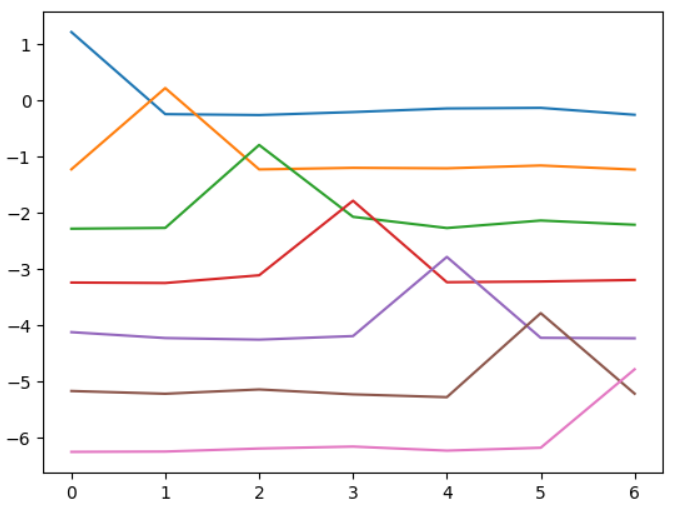 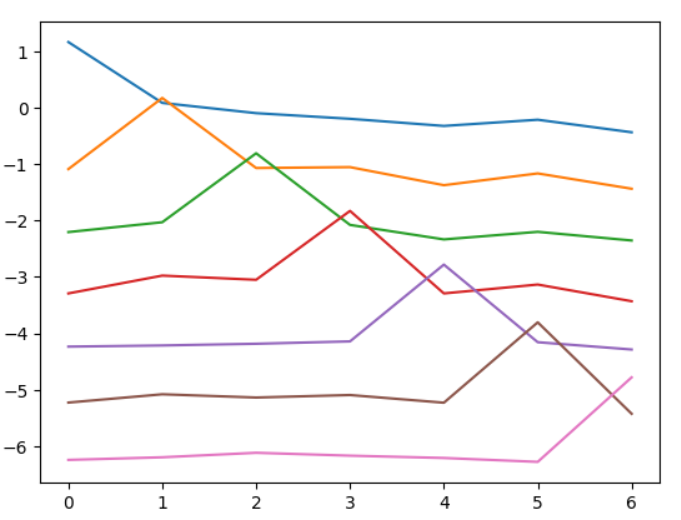 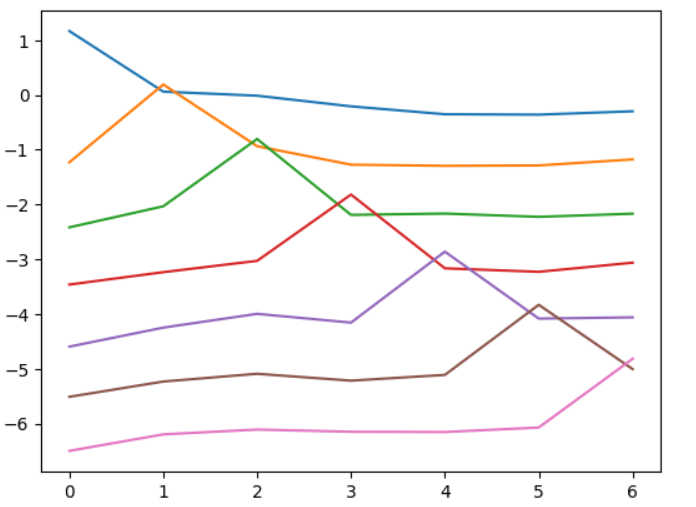 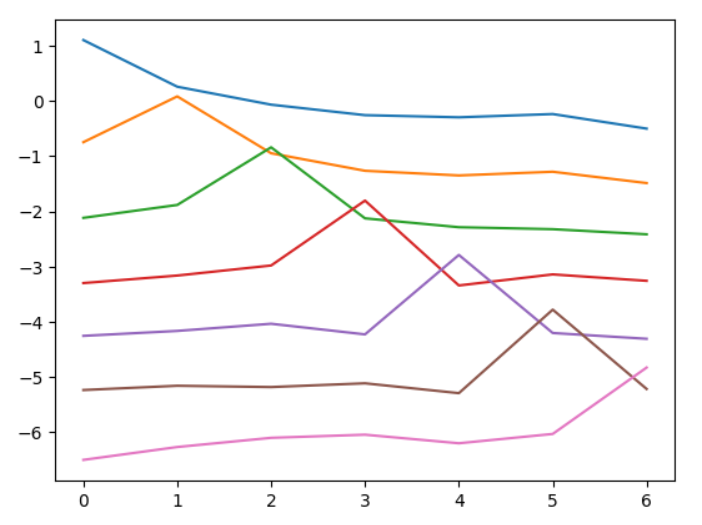

2. For initialized NoPE NanoGPT, after computing the attention weights using different shuffled inputs and combine them to approximate an attention weight distribution, for the followings:
    1. distribution for NoPE at the first layer
    2. distribution for NoPE at the 2nd layer
    3. distribution for NoPE at the 3rd layer
    4. distribution for NoPE at the last layer

    - 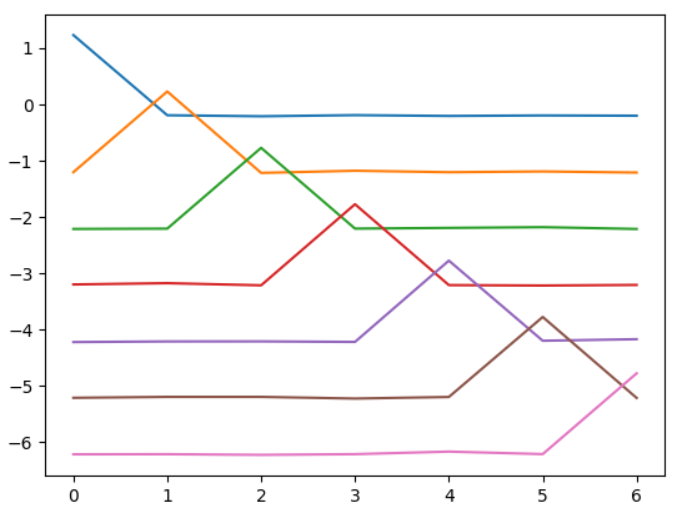 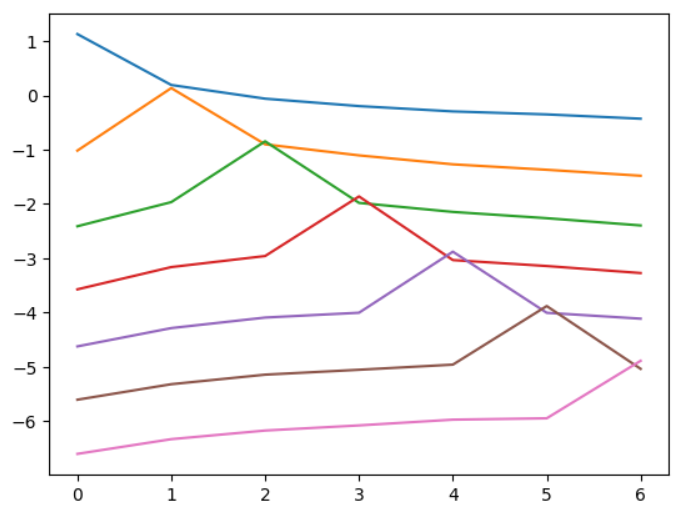 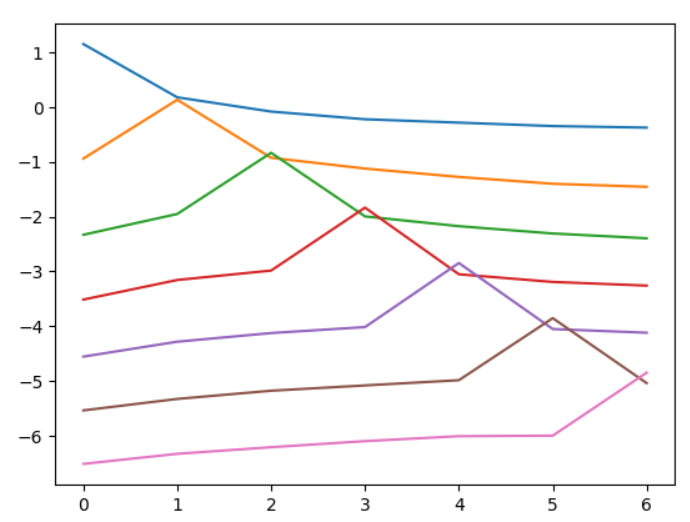 ![alt text](image.png)

3. Even when all tokens of the sequence are the same, for NoPE, the distribution will be broken due to numerical error.


4. For trained original NanoGPT, after computing the attention weights using different shuffled inputs and combine them to approximate an attention weight distribution, for the followings:
    1. distribution for NoPE at the first layer
    2. distribution for NoPE at the 2nd layer
    3. distribution for NoPE at the 3rd layer
    4. distribution for NoPE at the last layer
    - 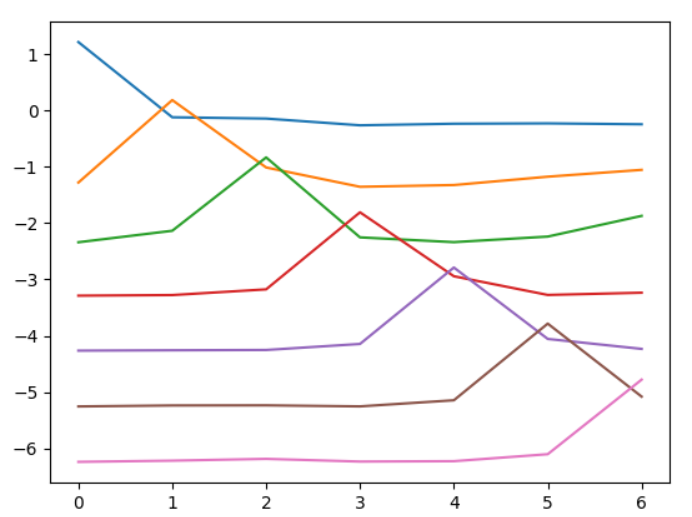 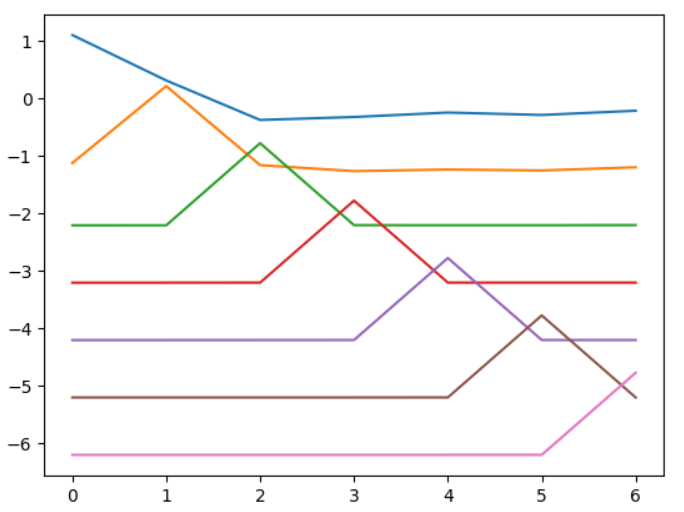 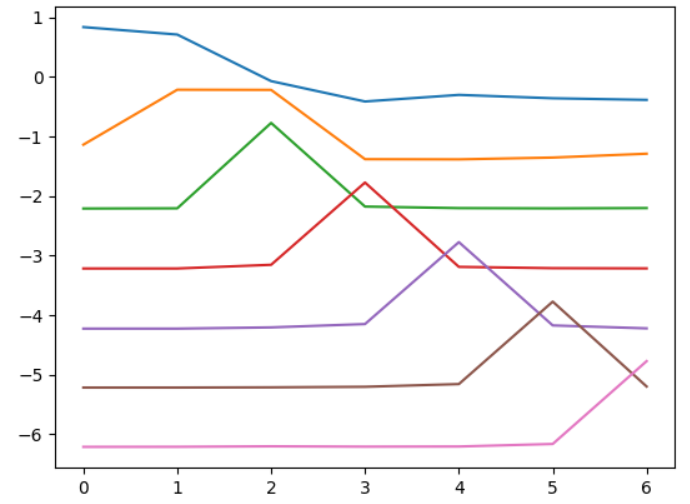 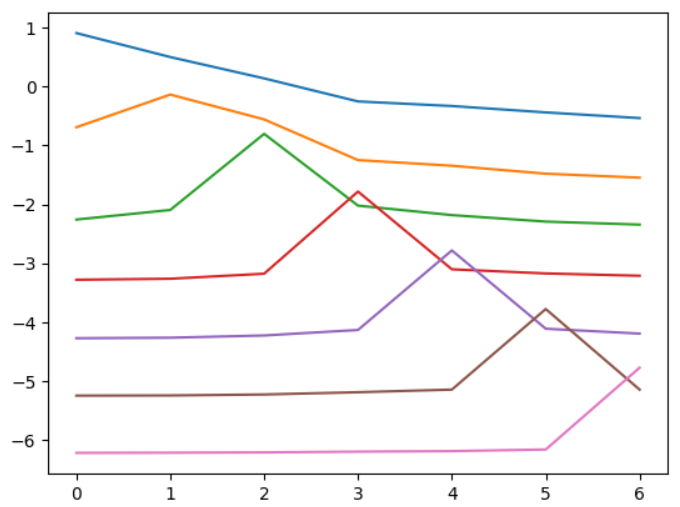

5. For trained NoPE NanoGPT, after computing the attention weights using different shuffled inputs and combine them to approximate an attention weight distribution, for the followings:
    1. distribution for NoPE at the first layer
    2. distribution for NoPE at the 2nd layer
    3. distribution for NoPE at the 3rd layer
    4. distribution for NoPE at the 4th layer

    - 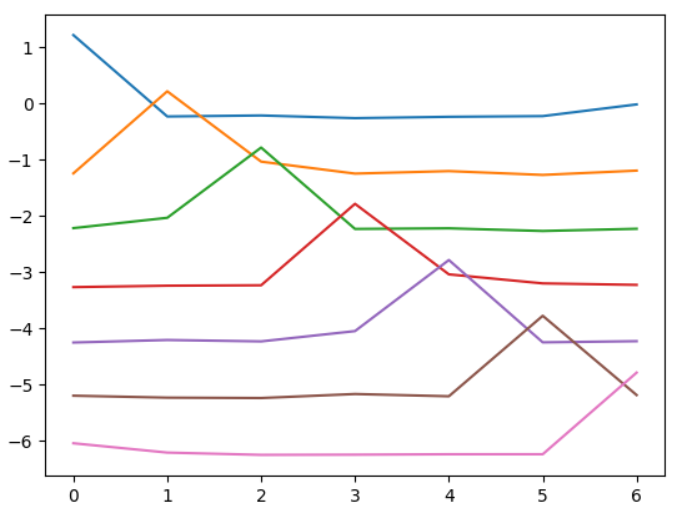 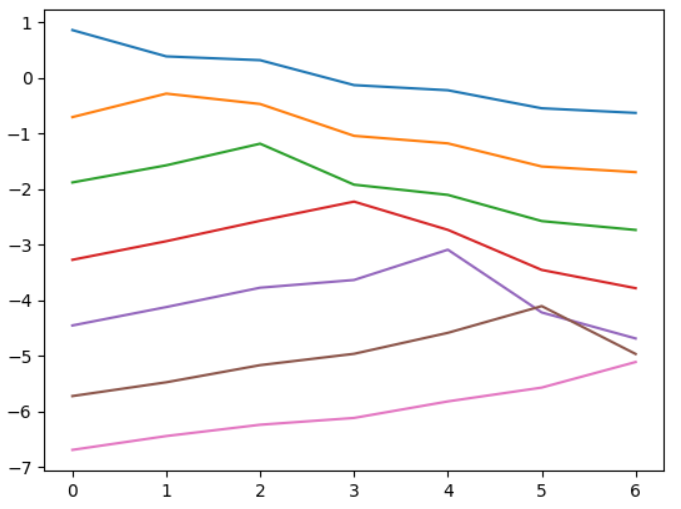 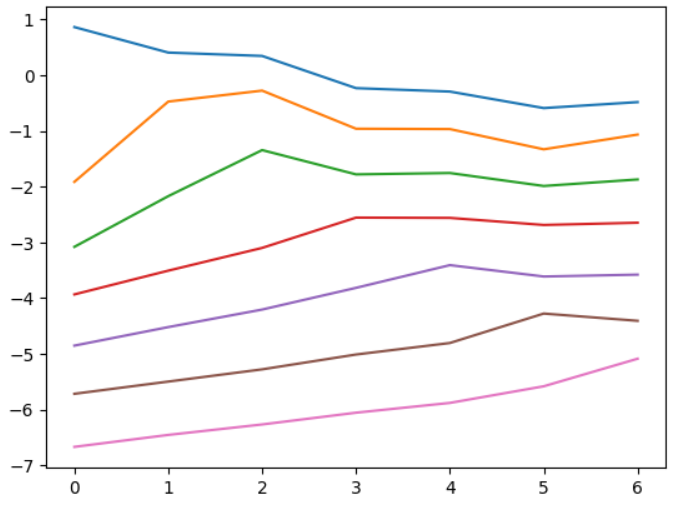 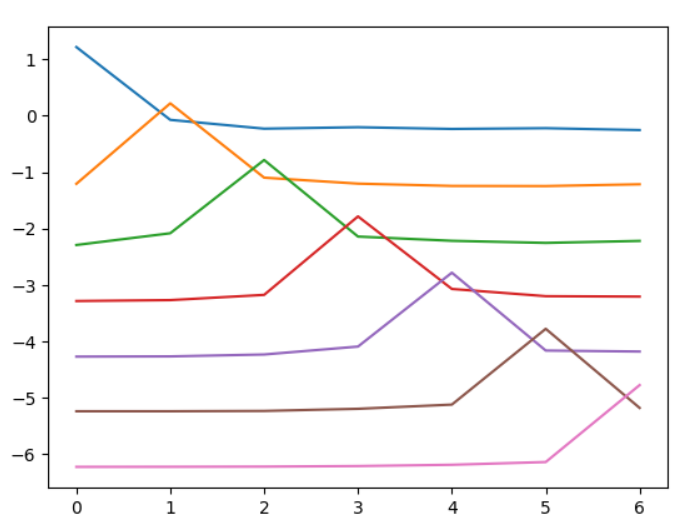

look at initialization of QK, different initialization to see if it is the same pattern.
fixing up thet paper (naccl)

## Activation Correlation

In [49]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob

fixed_length = 8
total_tokens = 2048
sample_num = 1024
all_level_input_act_list = []

rand_perm = True
if rand_perm:
  print('purmutation added')


model_list = []
for idx, (config_dir, model_config_fold) in enumerate(exp_list):
  glob_dir = config_dir.replace('[', '*').replace(']', '*')
  try:
    yaml_path = glob.glob(f'{glob_dir}/**/config.yaml')[0]
    csv_path = glob.glob(f'{glob_dir}/**/result.csv')[0]
    revised_glob_dir = '/'.join(yaml_path.split('/')[:-2])
    exp_list[idx][0] = revised_glob_dir
    exp_list[idx][1] = revised_glob_dir.split('/')[-1]

    config_dir = '/'.join(yaml_path.split('/')[:-2])
    with open(yaml_path) as f:
        config_dict = yaml.load(f, Loader=yaml.FullLoader)
    df = pd.read_csv(csv_path)
    
  except:
    print(f'no model {glob_dir}')
    continue

  ckpt = f"{config_dir}/ckpt_10000_acc.pt"
  # model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda')
  model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
  
  # model = GPT_nope(gptconfig)

  model.eval()
  model.to(device)
  model_list.append(model)


for level in range(1,7):
  level = level - 1
  input_act1_list = [list() for _ in range(len(model_list))]

  for i in range(0, 10): # try 5 batches
    X, Y, M, W = get_batch('train')
    # X = decode(X[0].tolist())
    X = ''.join([decode(X[i].tolist()) for i in range(X.shape[0])])[:total_tokens]
    # X_8 = list(map(lambda x: x[:fixed_length], filter(lambda x: len(x)>=fixed_length and x[fixed_length-1]=='=', X.split('\n'))))
    # X = torch.tensor(list(map(lambda x: encode(x), X_8)))
    X_n = np.array(list(X[:len(X)//fixed_length*fixed_length])).reshape(-1, fixed_length)
    # X_n = list(map(lambda x: x[:fixed_length], X))
    X = torch.tensor(list(map(lambda x: encode(x), X_n)))
    
    if rand_perm:
      for xidx in range(X.shape[0]):
        X[xidx] = X[xidx, torch.randperm(X[xidx].shape[0])] 
    # X = X.reshape(-1, fixed_length)
    # X = X[:sample_num]
    X = X.to(device)
    # print(X.shape)

    for midx, model in enumerate(model_list): 
      activation = {}
      def getActivation(name):
        # the hook signature
        def hook(model, input, output):
          activation[name] = output.detach()
        return hook
      # register forward hooks on the layers of choice
      if level >=0:
        h1 = model.transformer.h[level].register_forward_hook(getActivation(f'layer_{level}'))
        h2 = model.transformer.ln_f.register_forward_hook(getActivation('x_out'))
      else:
        h1 = model.transformer.wte.register_forward_hook(getActivation(f'layer_{level}'))
        h2 =  model.transformer.ln_f.register_forward_hook(getActivation('x_out'))

      with torch.no_grad():
        _ = model(X, M)

      h1.remove()
      h2.remove()

      acts = activation[f'layer_{level}'].detach().cpu().numpy()
      input_act1_list[midx].append(acts)


  for i in range(len(input_act1_list)):
    cur_input_act1 = np.concatenate(input_act1_list[i], axis=0)
    bs, l, dim = cur_input_act1.shape
    # print(cur_input_act1.shape)
    input_act1_list[i] = cur_input_act1.reshape(bs, l*dim)
    
  all_level_input_act_list.append(input_act1_list)
  

purmutation added
Using Flash Attention
Block 0: 0.0 | att_res False | perm 0.0 | mlp_res False | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 1: 0.0 | att_res False | perm 0.0 | mlp_res False | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 2: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 3: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 4: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 5: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
PE in use: nope
number of parameters: 10.66M
test_run
0 
1 
2 
3 
4 
5 
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(96, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_featur

In [50]:
from re import U
import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt




def standardize_rows(matrix):
    """Standardize each row of the matrix."""
    mean = matrix.mean(axis=1, keepdims=True)
    std = matrix.std(axis=1, keepdims=True)
    return (matrix - mean) / std

level_corr_mat_accum = []
corr_mat = None
u1, u2, u1_name, u2_name = None, None, None, None

@widgets.interact(idx1=(0, len(input_act1_list)-1), idx2=(0, len(input_act1_list)-1), level=(0,5))
def get_corr(idx1, level=0, save=False,  abs=True, save_all=False, accumulate_all=False, is_rand_init=False):
    global corr_mat
    global u1, u2, u1_name, u2_name
    rand_state = 'init_' if is_rand_init else ''
    if not (save_all or accumulate_all):
        idx2 = idx1
        input_act1_list = all_level_input_act_list[level]
        u1, u2 = input_act1_list[idx1], input_act1_list[idx2]
        u1 = u1.T
        u2 = u2.T
        print(exp_list[idx1][0].split('sd')[-1], exp_list[idx2][0].split('sd')[-1])

        print(u2.shape)

        # Standardize each row of u1 and u2
        u1_standardized = standardize_rows(u1)
        u2_standardized = standardize_rows(u2)
        # u1_standardized = u1
        # u2_standardized = u2
        

        # Compute the correlation matrix
        corr_mat = np.dot(u1_standardized, u2_standardized.T) / (u1.shape[1] )
        if abs:
            corr_mat = np.abs(corr_mat)
        else:
            pass
        vec_dim = corr_mat.shape[0]//8
        total_sum = np.abs(corr_mat).sum()
        block_sum = 0
        for i in range(0, len(corr_mat), vec_dim):
            block_sum += np.abs(corr_mat[i:i+vec_dim, i:i+vec_dim]).sum()
        ratio = block_sum/(total_sum-block_sum)

        # Assuming you have calculated 'corr_mat' as described in the previous answer

        # Create a heatmap of corr_mat
        plt.figure(figsize=(12, 10), dpi=120)
        # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
        plt.imshow(corr_mat, cmap='coolwarm', interpolation='nearest')

        extra_text = 'Absolute ' if abs else ''
        plt.colorbar(label=f'{extra_text}Correlation Coefficient')

        # Set axis labels and title
        # plt.xlabel('U2 Entries')
        # plt.ylabel('U1 Entries')

        # Show the plot
        nope1 = 'nope_' if 'nope' in exp_list[idx1][1] else ''
        u1_name = '_'.join(exp_list[idx1][1].split('_')[2:])
        u1_name = nope1 + u1_name.split('_')[-1] + '_' + '_'.join(u1_name.split('_')[:-1])
        nope2 = 'nope_' if 'nope' in exp_list[idx1][1] else ''
        u2_name = '_'.join(exp_list[idx2][1].split('_')[2:])
        u2_name = nope2+u2_name.split('_')[-1] + '_' +'_'.join(u2_name.split('_')[:-1])

        extra_self = 'Self' if u1_name == u2_name else ''
        # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
        print(u1_name, u2_name)
        if save:
            os.makedirs('./saved_plots_corr/', exist_ok=True)
            plt.savefig(f'./saved_plots_corr/{rand_state}_{u1_name}_VS_{u2_name}_layer{level}_{ratio:.03f}_{abs}.svg')
        
        # close img
        # plt.close()
        plt.show()
    else:
        for level in range(len(all_level_input_act_list)):
            input_act1_list = all_level_input_act_list[level]
            global level_corr_mat_accum
            for idx1 in tqdm(range(len(input_act1_list))):
                idx2 = idx1
                u1, u2 = input_act1_list[idx1], input_act1_list[idx2]
                u1 = u1.T
                u2 = u2.T

                u1_standardized = standardize_rows(u1)
                u2_standardized = standardize_rows(u2)
                # u1_standardized = u1
                # u2_standardized = u2
                

                # Compute the correlation matrix
                corr_mat = np.dot(u1_standardized, u2_standardized.T) / (u1.shape[1] )
                if abs:
                    corr_mat = np.abs(corr_mat)
                else:
                    pass
            
                if accumulate_all:
                    level_corr_mat_accum.append(corr_mat[None, ...])
                if not save_all:
                    continue 

                vec_dim = corr_mat.shape[0]//8
                total_sum = np.abs(corr_mat).sum()
                block_sum = 0
                for i in range(0, len(corr_mat), vec_dim):
                    block_sum += np.abs(corr_mat[i:i+vec_dim, i:i+vec_dim]).sum()
                ratio = block_sum/(total_sum-block_sum)

                # Assuming you have calculated 'corr_mat' as described in the previous answer

                # Create a heatmap of corr_mat
                plt.figure(figsize=(12, 10), dpi=120)
                # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
                plt.imshow(corr_mat, cmap='coolwarm', interpolation='nearest')

                extra_text = 'Absolute ' if abs else ''
                plt.colorbar(label=f'{extra_text}Correlation Coefficient')

                # Set axis labels and title
                # plt.xlabel('U2 Entries')
                # plt.ylabel('U1 Entries')

                # Show the plot
                nope1 = 'nope_' if 'nope' in exp_list[idx1][1] else ''
                u1_name = '_'.join(exp_list[idx1][1].split('_')[2:])
                u1_name = nope1 + u1_name.split('_')[-1] + '_' + '_'.join(u1_name.split('_')[:-1])
                nope2 = 'nope_' if 'nope' in exp_list[idx1][1] else ''
                u2_name = '_'.join(exp_list[idx2][1].split('_')[2:])
                u2_name = nope2+u2_name.split('_')[-1] + '_' +'_'.join(u2_name.split('_')[:-1])

                extra_self = 'Self' if u1_name == u2_name else ''
                # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
                # print(ratio)
                # print(u1_name, u2_name)
                os.makedirs('./saved_plots_corr/', exist_ok=True)
                plt.savefig(f'./saved_plots_corr/{rand_state}{u1_name}_VS_{u2_name}_layer{level}_{ratio:.03f}_{abs}.svg')
                
                # close img
                plt.close()
                # plt.show()
            if accumulate_all:
                level_corr_mat_accum = np.vstack(level_corr_mat_accum)
                print(level_corr_mat_accum.shape)
                level_corr_mat_accum = level_corr_mat_accum.mean(axis=0)
                # Create a heatmap of corr_mat
                plt.figure(figsize=(12, 10), dpi=120)
                # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
                plt.imshow(level_corr_mat_accum, cmap='coolwarm', interpolation='nearest')

                extra_text = 'Absolute ' if abs else ''
                plt.colorbar(label=f'{extra_text}Correlation Coefficient')
                plt.show()
                corr_mat  =  level_corr_mat_accum
                level_corr_mat_accum = []

# idxes = [
# # [0,0], [0,1], [0,2], [0,3], [0,4],
# # [1,1], [2,2], [3,3], [4,4],
# # [4,1], [4,2], [4,3], 
# [1,2], [1,3],
# ]
# from tqdm.auto import tqdm
# for idx1, idx2 in tqdm(idxes):
#     get_corr(idx1, idx2, save=True)
    
# all residual vs picking ones that are illustrative

interactive(children=(IntSlider(value=10, description='idx1', max=21), IntSlider(value=0, description='level',…

361600


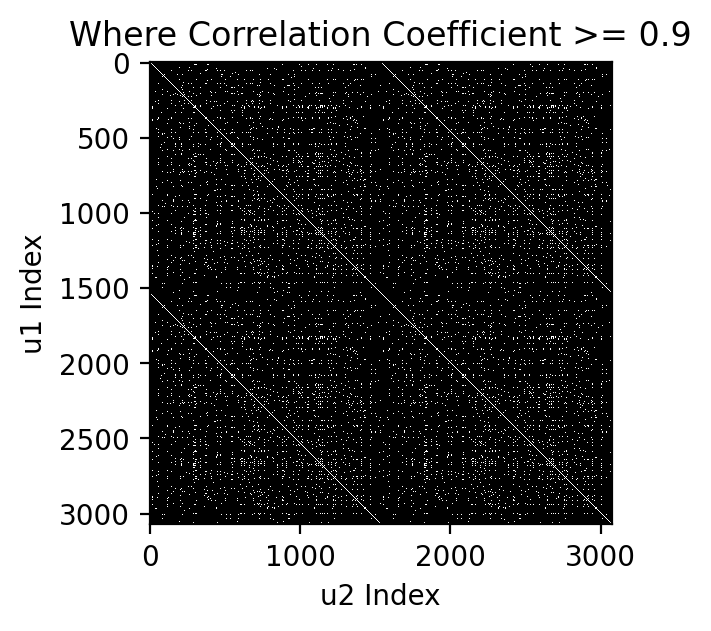

In [46]:
TH = 0.9
print((corr_mat >= TH).sum())
idxes = np.nonzero(corr_mat >= TH)
size = np.vstack(idxes).max()+1
sub_mat = np.zeros((size, size))
sub_mat[idxes] = 1

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have calculated 'corr_mat' as described in the previous answer

# Create a heatmap of corr_mat
plt.figure(figsize=(4, 3), dpi=200)
plt.imshow(sub_mat, cmap='grey', interpolation='nearest')
# plt.colorbar(label=)

# Set axis labels and title
plt.xlabel('u2 Index')
plt.ylabel('u1 Index')
plt.title('Where Correlation Coefficient >= 0.9')
# Show the plot
plt.show()

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.stats import pearsonr
# @widgets.interact(idx=(0, len(u1)-1), idx2=(0, len(u2)-1), continuous_update=True)
@widgets.interact(idx=(0,len(idxes[0])), save=[False, True], continuous_update=True,)
def show(idx, save=False):
  idx, idx2 = idxes[0][idx], idxes[1][idx]
  plt.figure(figsize=(4, 3), dpi=100)
  plt.scatter(u1[idx, :], u2[idx2, :], alpha=0.5)
  print(pearsonr(u1[idx, :], u2[idx2, :])[0])
  divisor = len(u1)//8
  r1, c1 = idx//divisor, idx%divisor
  r2, c2 = idx2//divisor, idx2%divisor
  plt.title(f"U1[{r1, c1}] vs U2[{r2, c2}] (corr={pearsonr(u1[idx, :], u2[idx2, :])[0]:.3f})")
  # plt.show()
  if save:
    os.makedirs(f'./saved_plots/{u1_name}_VS_{u2_name}/', exist_ok=True)
    plt.savefig(f'./saved_plots/{u1_name}_VS_{u2_name}/U1[{idx}]_vs_U2[{idx2}].svg')
  plt.show()
  # return

NameError: name 'idxes' is not defined

## PCA visualizaiton

In [19]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
from IPython.utils import io



input_act1_list = []
# for config_dir, model_config_fold in exp_list:
#   with open(f'{config_dir}/{model_config_fold}/config.yaml') as f:
#     config_dict = yaml.load(f, Loader=yaml.FullLoader)
#   ckpt = f"{config_dir}/ckpt_10000_final.pt"
#   model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda')

for config_dir, model_config_fold in exp_list:
  glob_dir = config_dir.replace('[', '*').replace(']', '*')
  yaml_path = glob.glob(f'{glob_dir}/**/config.yaml')[0]
  config_dir = '/'.join(yaml_path.split('/')[:-2])
  with open(yaml_path) as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
  # ckpt = glob.glob(f"{config_dir}/ckpt_**_acc.pt", recursive=True)[0]
  # ckpt = glob.glob(f'{glob_dir}/ckpt_**_acc.pt')[0]
  ckpt = glob.glob(f'{glob_dir}/ckpt_**.pt')[0]
    
  with io.capture_output() as captured:
    # model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
    model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
    # gptconfig.use_pe = 'sin'
    # model = GPT_nope(gptconfig)

  cur_input_act1_list = []
  # for i in range(0, 3):
  # model.transformer.h[0].permute = False
  # prompts = [
  #   f"${823}" + '+' + f"{8}"*3 + '=',
  #   f"${238}" + '+' + f"{8}"*3 + '='
  # ]
  zs = np.zeros(12).astype(np.int64)
  n_1s = 3
  zs[np.random.permutation(12)[:n_1s]] = 1
  str_zs = ''.join(map(str, zs))
  

  prompts = [
    # f'\nparity({str_zs})=',
    # '\nparity(100101010000)='
    # '\nparity(010101000101)='
    # 'parity(000010101001)=',
    '    $331+123=',
    # 'parity(001111000001)='
    # '123+456'
  ]
  # prompts = [
  #   f"${623}" + '+' + f"{5}"*3 + '=',
  #   f"${632}" + '+' + f"{5}"*3 + '='
  # ]
  for i in range(0, 1): # try 10 batches

    # prompt = "$" + f"{i}"*3 + f"{i}"*6  
    # prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
    # prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
    prompt = prompts[i]




    activation = {}
    def getActivation(name):
      # the hook signature
      def hook(model, input, output):
        activation[name] = output.detach()
      return hook
    # register forward hooks on the layers of choice
    h1 = model.transformer.h[1].register_forward_hook(getActivation('layer_1'))
    h2 = model.transformer.ln_f.register_forward_hook(getActivation('x_out'))
    # out_text = generate_output(model, prompt, max_new_tokens=5)
    out_text = generate_output(model, prompt, max_new_tokens=4, causal_training=causal_training)


    h1.remove()
    h2.remove()
    model_name = config_dir.split('/')[-1]
    print(model_name)
    PCA_analysis(prompt, activation['x_out'][0], out_text, config_dir)
    


torch.Size([1, 13, 13])
torch.Size([1, 13])
torch.Size([1, 13, 13])
add3_nc_sd240_T2403240318_res=[0, 1, 2, 3, 4, 5]


    $331+123=$$44
[0.37671003 0.21642588]


In [161]:
start, start_train

('FILE:data/parity/test_parity_2000.txt',
 'FILE:data/parity/train_parity_2000.txt')

In [163]:
from threading import main_thread
from pe_investigation import main_utils
# start_train = None
reverse_ab = False
reverse_c = False
zero_pad = False
algo_reason = False
add_space = False
config['causal_training'] = False

config['start'] = start
main_utils.evaluate_addition_batch(config, model, ctx, encode, decode, verbose=True, num_digit=num_digit, zero_pad=zero_pad, 
                                    reverse_ab=reverse_ab, reverse_c=reverse_c, algo_reason=algo_reason, 
                                    binary=binary, data_type=data_type, operator=operator, data_format=data_format)

evaluating addition from: FILE:data/parity/test_parity_2000.txt
Evaluating Addition using test data file: data/parity/test_parity_2000.txt


  0%|          | 0/16 [00:00<?, ?it/s]

outputs(x):  parity(011101101101)=1
wrong  : parity(011101101101)=1
correct: parity(011101101101)=0
outputs(x):  parity(111101111011)=1
wrong  : parity(111101111011)=1
correct: parity(111101111011)=0
outputs(x):  parity(110101111001)=1
wrong  : parity(110101111001)=1
correct: parity(110101111001)=0
outputs(x):  parity(111110011110)=0
wrong  : parity(111110011110)=0
correct: parity(111110011110)=1
outputs(x):  parity(000111000100)=1
wrong  : parity(000111000100)=1
correct: parity(000111000100)=0
outputs(x):  parity(001111111100)=1
wrong  : parity(001111111100)=1
correct: parity(001111111100)=0
outputs(x):  parity(110101111110)=0
wrong  : parity(110101111110)=0
correct: parity(110101111110)=1
outputs(x):  parity(111101101010)=1
wrong  : parity(111101101010)=1
correct: parity(111101101010)=0
outputs(x):  parity(110111101001)=1
wrong  : parity(110111101001)=1
correct: parity(110111101001)=0
outputs(x):  parity(101110111001)=1
wrong  : parity(101110111001)=1
correct: parity(101110111001)=0


 25%|██▌       | 4/16 [00:00<00:00, 39.92it/s]

outputs(x):  parity(111101110110)=0
wrong  : parity(111101110110)=0
correct: parity(111101110110)=1
outputs(x):  parity(001111101011)=1
wrong  : parity(001111101011)=1
correct: parity(001111101011)=0
outputs(x):  parity(111110110100)=1
wrong  : parity(111110110100)=1
correct: parity(111110110100)=0
outputs(x):  parity(011011111100)=1
wrong  : parity(011011111100)=1
correct: parity(011011111100)=0
outputs(x):  parity(000101110000)=1
wrong  : parity(000101110000)=1
correct: parity(000101110000)=0
outputs(x):  parity(100111111100)=1
wrong  : parity(100111111100)=1
correct: parity(100111111100)=0
outputs(x):  parity(101111011100)=1
wrong  : parity(101111011100)=1
correct: parity(101111011100)=0
outputs(x):  parity(111010101110)=1
wrong  : parity(111010101110)=1
correct: parity(111010101110)=0
outputs(x):  parity(000000011110)=1
wrong  : parity(000000011110)=1
correct: parity(000000011110)=0
outputs(x):  parity(011110111101)=0
wrong  : parity(011110111101)=0
correct: parity(011110111101)=1


 56%|█████▋    | 9/16 [00:00<00:00, 39.95it/s]

outputs(x):  parity(001111111111)=1
wrong  : parity(001111111111)=1
correct: parity(001111111111)=0
outputs(x):  parity(101011000000)=1
wrong  : parity(101011000000)=1
correct: parity(101011000000)=0
outputs(x):  parity(001000111000)=1
wrong  : parity(001000111000)=1
correct: parity(001000111000)=0
outputs(x):  parity(000100001100)=0
wrong  : parity(000100001100)=0
correct: parity(000100001100)=1
outputs(x):  parity(111011100111)=0
wrong  : parity(111011100111)=0
correct: parity(111011100111)=1
outputs(x):  parity(111001111010)=1
wrong  : parity(111001111010)=1
correct: parity(111001111010)=0
outputs(x):  parity(110111001111)=0
wrong  : parity(110111001111)=0
correct: parity(110111001111)=1
outputs(x):  parity(011111001110)=1
wrong  : parity(011111001110)=1
correct: parity(011111001110)=0
outputs(x):  parity(111011010111)=0
wrong  : parity(111011010111)=0
correct: parity(111011010111)=1
outputs(x):  parity(111011111011)=1
wrong  : parity(111011111011)=1
correct: parity(111011111011)=0


100%|██████████| 16/16 [00:00<00:00, 48.39it/s]

outputs(x):  parity(101011111111)=1
wrong  : parity(101011111111)=1
correct: parity(101011111111)=0
outputs(x):  parity(111111011011)=1
wrong  : parity(111111011011)=1
correct: parity(111111011011)=0
outputs(x):  parity(001001011000)=1
wrong  : parity(001001011000)=1
correct: parity(001001011000)=0
outputs(x):  parity(000011100010)=1
wrong  : parity(000011100010)=1
correct: parity(000011100010)=0
outputs(x):  parity(001000010100)=0
wrong  : parity(001000010100)=0
correct: parity(001000010100)=1
outputs(x):  parity(101110011111)=0
wrong  : parity(101110011111)=0
correct: parity(101110011111)=1
outputs(x):  parity(000001110010)=1
wrong  : parity(000001110010)=1
correct: parity(000001110010)=0
outputs(x):  parity(111101110010)=1
wrong  : parity(111101110010)=1
correct: parity(111101110010)=0
outputs(x):  parity(101110110110)=1
wrong  : parity(101110110110)=1
correct: parity(101110110110)=0
outputs(x):  parity(111001101110)=1
wrong  : parity(111001101110)=1
correct: parity(111001101110)=0


(83.89999999999999,
 {'carry0': 83.89999999999999,
  'carry1': nan,
  'carry2': nan,
  'carry3': nan,
  'carry4': nan,
  'carry5': nan})

interesting: for a causal model with pe, with or without "\n" makes a 180 degree difference in outcome !!!!!

## Original_model_pe_PCA

In [104]:
x =  model.transformer.wpe.weight.cpu().detach().numpy()
x.shape

(256, 384)

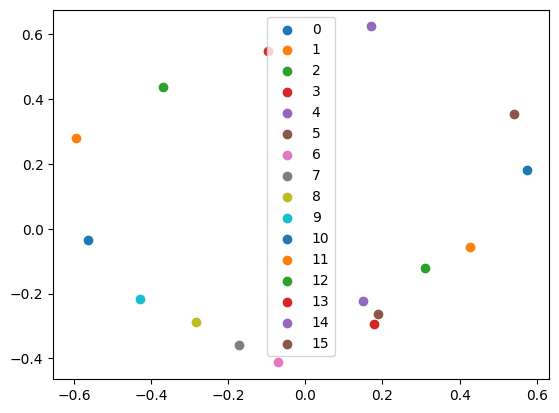

[[ 0.57404906  0.18091261]
 [ 0.42592266 -0.0552854 ]
 [ 0.3105009  -0.12041674]
 [ 0.17746264 -0.29408967]
 [ 0.14986224 -0.22194865]
 [ 0.18950118 -0.26214504]
 [-0.07151226 -0.41235036]
 [-0.1722473  -0.35763952]
 [-0.28476417 -0.28858176]
 [-0.42833287 -0.21658199]
 [-0.5626896  -0.03320071]
 [-0.59554493  0.28155863]
 [-0.36853096  0.43710715]
 [-0.0961227   0.54890597]
 [ 0.17018779  0.6244606 ]
 [ 0.5404304   0.352905  ]]
[0.12837423 0.11656444]


In [105]:
x =  model.transformer.wpe.weight.cpu().detach().numpy()
from sklearn.decomposition import PCA
# select sample maybe from test set
# but if, different digits seems to be encoded the same way, than it has a patter
pca = PCA(n_components=2)
new_x = pca.fit_transform(x)
new_x = new_x[::16]
import matplotlib.pyplot as plt
for text, pt in zip(range(len(new_x)), new_x, ):
  plt.scatter(pt[0], pt[1], label=text)
  
plt.legend()
plt.show()
print(new_x)
print(pca.explained_variance_ratio_)

## Probing

In [55]:
gptconfig

GPTConfig(block_size=256, vocab_size=96, n_layer=6, n_head=6, n_embd=384, dropout=0.2, bias=False, use_flash=True, use_residual=[0.0, 1.0, 1.0, 1.0, 1.0, 1.0], no_att_residual=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], no_mlp_residual=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], use_pe='nope', layerwise_pe=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], layer_pe=False, permute=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], not_causal=[0.0, 6.0, 0.0, 0.0, 0.0, 0.0])

In [40]:
exp_list

[['./outputs/residual_exp/addition_reverse_sd111_T2402040225_res=[0, 1, 2, 3, 4, 5]',
  'addition_reverse_sd111_T2402040225_res=[0, 1, 2, 3, 4, 5]'],
 ['./outputs/residual_exp/addition_reverse_sd555_T2402030324_res=[1, 2, 3, 4, 5]',
  'addition_reverse_sd555_T2402030324_res=[1, 2, 3, 4, 5]'],
 ['./outputs/residual_exp/addition_reverse_sd555_T2402030428_res=[0, 1, 2, 4, 5]',
  'addition_reverse_sd555_T2402030428_res=[0, 1, 2, 4, 5]'],
 ['./outputs/residual_exp/addition_reverse_sd555_T2402021605_res=[2, 3, 4, 5]',
  'addition_reverse_sd555_T2402021605_res=[2, 3, 4, 5]'],
 ['./outputs/nope_residual_exp/addition_reverse_sd111_T2402040212_nope_res=[0, 1, 2, 3, 4, 5]',
  'addition_reverse_sd111_T2402040212_nope_res=[0, 1, 2, 3, 4, 5]'],
 ['./outputs/nope_residual_exp/addition_reverse_sd555_T2402020708_nope_res=[1, 2, 3, 4, 5]',
  'addition_reverse_sd555_T2402020708_nope_res=[1, 2, 3, 4, 5]'],
 ['./outputs/nope_residual_exp/addition_reverse_sd555_T2402020708_nope_res=[1, 2, 3, 4, 5]',
  'addi

In [17]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
fixed_length = 8
sample_num = 1024
all_level_input_act_list = []

model_list = []
for idx, (config_dir, model_config_fold) in enumerate(exp_list):
  glob_dir = config_dir.replace('[', '[[]')
  yaml_path = glob.glob(f'{glob_dir}/**/config.yaml')[0]
  revised_glob_dir = '/'.join(yaml_path.split('/')[:-2])
  exp_list[idx][0] = revised_glob_dir
  exp_list[idx][1] = revised_glob_dir.split('/')[-1]
  
  with open(yaml_path) as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
  ckpt = f"{revised_glob_dir}/ckpt_10000_acc.pt"
  model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)

  # gptconfig.not_causal = [1]*6  
  # model = GPT_nope(GPTConfig_nope())
  # model = GPT_nope(gptconfig)

  # for i in range(len(model.transformer.h)):
  #   model.transformer.h[i].attn._reset_parameters()
  #   model.transformer.h[i].mlp._reset_parameters()
  # model.apply(model._init_weights)

  model.eval()
  model.to(device)
  model_list.append(model)


for level in range(0, 8):
  level = level - 1
  input_act1_list = [list() for _ in range(len(model_list))]

  for i in range(0, 1): # try 5 batches
    X, Y = get_batch('train')
    X = decode(X[0].tolist())
    X_8 = list(map(lambda x: x[:fixed_length], filter(lambda x: len(x)>=fixed_length and x[fixed_length-1]=='=', X.split('\n'))))
    X_8 = [''.join(list(np.array(list(x))[np.random.permutation(len(x))])) for x in X_8]
    X = torch.tensor(list(map(lambda x: encode(x), X_8)))
    # X = X.reshape(-1, fixed_length)
    # X = X[:sample_num]
    X = X.to(device)

    for midx, model in enumerate(model_list): 
      activation = {}
      def getActivation(name):
        # the hook signature
        def hook(model, input, output):
          activation[name] = output.detach()
        return hook
      # register forward hooks on the layers of choice

      if level == 6:
        h1 = model.transformer.ln_f.register_forward_hook(getActivation(f'layer_{level}'))
      elif level == -1:
        h1 = model.transformer.wte.register_forward_hook(getActivation(f'layer_{level}'))
      else:
        h1 = model.transformer.h[level].ln_1.register_forward_hook(getActivation(f'layer_{level}'))
        

      with torch.no_grad():
        _ = model(X)

      h1.remove()

      acts = activation[f'layer_{level}'].detach().cpu().numpy()
      input_act1_list[midx].append(acts)
      # outs = activation['x_out'].detach().cpu().numpy()
      # input_act1_list[midx].append(outs)


  for i in range(len(input_act1_list)):
    print(len(input_act1_list[i]))
    cur_input_act1 = np.concatenate(input_act1_list[i], axis=0)
    bs, l, dim = cur_input_act1.shape
    targets = np.zeros((bs, l)) + np.arange(l)[None, ...]
    print(cur_input_act1.shape)
    input_act1_list[i] = (cur_input_act1, targets)
    
  all_level_input_act_list.append(input_act1_list)
  

Using Flash Attention
Block 0: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 1: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 2: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 3: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 4: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 5: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
PE in use: original
number of parameters: 10.66M
test_run
0 
1 
2 
3 
4 
5 
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(96, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_featur

In [18]:
len(all_level_input_act_list[0][1][1])

# do a scklearn linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets

def crossing(X, y):
    X_cross = []
    y_cross = []
    for i in range(len(X)):
        for j in range(len(X)):
            if i != j:
                X_cross.append(X[i] * X[j])
                y_cross.append(np.abs(y[i] - y[j]))
    X = np.array(X_cross)
    y = np.array(y_cross)
    return X, y

@widgets.interact(layer=(-1, 6), model_idx=(0, len(all_level_input_act_list[0])-1))
def probe_layer(layer=-1, model_idx = 0):
    layer = layer + 1
    print(exp_list[model_idx][0])
    X = all_level_input_act_list[layer][model_idx][0]
    y = all_level_input_act_list[layer][model_idx][1]

   


    # X = np.random.rand(*y.shape,10)
    X = X.reshape(-1, X.shape[-1])
    y = y.reshape(-1)
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
    y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

    X_train, y_train = crossing(X, y)
    X_test, y_test = crossing(X, y)


    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = LinearRegression().fit(X_train, y_train)
    # X_test = X_train
    # y_test = y_train
    y_pred = reg.predict(X_test)
    print(mean_squared_error(y_test, y_pred))
    print(reg.score(X_test, y_test))
    print(y_test[:10])
    print(y_pred[:10])

    # print('coef:', reg.coef_)
    plt.plot(reg.coef_)
    plt.show()

    mav = []
    for i in range(10):
        plt.plot(X_test[i])
        mav.append(np.abs(X_test[i]).mean())
    plt.show()

    print(list(zip(y_test[:10], mav)))

    mav = []
    for i in range(len(y_test)):
        mav.append(np.abs(X_test[i]).mean())


    # plt.scatter(y_test, mav, s=20, alpha=0.2)
    # plt.show()
    print(y_test.shape)
    
    
    plt.scatter(y_test, y_pred, s=20, alpha=0.2)

# normalize the input and do again

interactive(children=(IntSlider(value=-1, description='layer', max=6, min=-1), IntSlider(value=0, description=…

1. Nope and original behaves differently
2. When organized and unorganized, the activation output from the trained model is different, meaning that the model somehow also semantically managed the position of numbers and symbos 
3. For original pe, the regression model must be memorizing the absolute position initialized randomly at the start of the model. But that didn't explain why NOPE can also get positions right? Then there must be something permanent inside the model that indicates the positions, emm, such as a fixed bias?
4. If looking closely at the activations from layers without skip 


Maybe check why noncausal still doesn't work

* check random initialization problem

* Want to actually check that empirically Qx \cdot Ky is maximized
(usually) when x\approx y
    - could be Wk making W_ky more similar to W_kx
    - \sum a_i b_i (W_Q Z_i) (W_k Z_i) where Z_i can be the pca basis / or any other spectral decomposition

... an evidence that residual connection is preserving the locality of r.vec. x

... Hypothesis: signs tend to be the same for z1=z2 and different otherwise

* Want to compute the rank of
    - with
        - (1) Transformers with random initialization
        - (2) Transformers at convergence

    - for
       - (a) full residual connections
       - (b) no residual connections
       - (c) some residual connections

check rank degeneration: PCA -> compute the ratio 
- i.e. a1^2 / sum(ai^2) 
- plz see how the paper measures the rank degeneration 

* Want to check what happens when the residual connections we ablate
are not consecutive (both non-consecutive layers, and when things
taken out are pre-MLP/post-MLP)


* Fix the description of the correlation img
    - Collect the ratio from the graph and put into a table
    - generate the image for all experiments we have

- emperically validate qk, if vectors points in the same direction, othen kx dot qy should be high (for trained k,q)
    - Plot the correlation on this: QxdotKx vs xdoty 
- description for correlation matrix

or x being actual inputs $x \in R^d$, project x using K and Q (for a lot of x) would be generally a projection into to the same subspace, namely $Kx \cdot Qx$ be high
    - PCA on K{x}, project on the first 100 components
    - project on the first 100 components of Q{x}

$K{x} : subspace {Kx| x \in R^d}$
compare projecting K{x} on the principal components of Q{x} to projecting K{x} on the standard basis
(n.b., projecting on the first 100 components of the standard basis is just taking the first 100 coordinates)

[6. 7. 5. 7. 1. 6. 6. 5. 7. 1.]
[5.741754   6.9774055  5.0440187  7.2550983  1.1019306  6.0713177
 6.059374   5.0022345  7.029934   0.92898464]
[-2.0429568  -2.0866804   0.5149617  -4.452426   -2.181752   -3.647598
 -3.011921   -1.1200063  -0.71596277 -0.01247239]


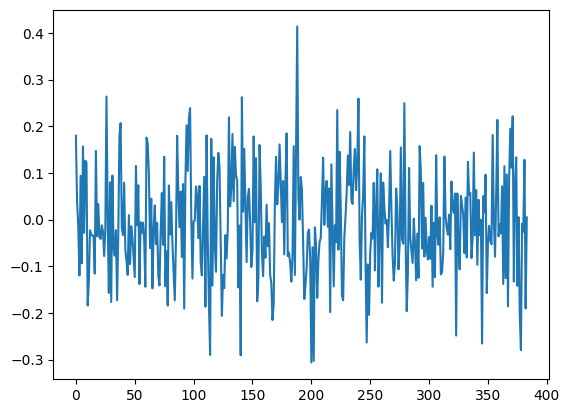

In [59]:
idx = 24
plt.plot(X_train[idx])
print(y_train[:10])
print(reg.predict(X_train[:10][ :]))
print(X_train[:10].sum(axis=-1))


In [ ]:
## define a torch lstm model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial
from transformers import AutoTokenizer

device = torch.device('cuda:0')

## use a tokenizer from the bert model
# bert_model = transformers.pipeline('sentiment-analysis', top_k=None)

# class Distilbert_LSTM_regressor(nn.Module):
#     def __init__(self, input_size=768, hidden_size=256, num_layers=3, bidirectional=True):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         # self.bert_model = bert_model
#         self.embedding = bert_model.model.distilbert.eval()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
#         out_size = hidden_size * 2 if bidirectional else hidden_size
#         self.fc = nn.Linear(out_size, 1)
#         self.double()
#     def forward(self, x):
#         with torch.no_grad():
#             bert_embeddings = self.embedding(**x)
#         self.lstm.flatten_parameters()
#         out, _ = self.lstm(bert_embeddings.last_hidden_state)
#         out = self.fc(out[:, -1, :])
#         return out


class Linear_regressor(nn.Module):
    def __init__(self, input_size=, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(50265, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        self.double()
    def forward(self, x):
        embeddings = self.embedding(x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(embeddings)
        out = self.fc(out[:, -1, :])
        return out



class LSTM_regressor(nn.Module):
    def __init__(self, input_size=768, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(50265, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        self.double()
    def forward(self, x):
        embeddings = self.embedding(x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(embeddings)
        out = self.fc(out[:, -1, :])
        return out

class LLM_LSTM_regressor(nn.Module):
    def __init__(self, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.bert_model = bert_model
        # input_size = llm.config.d_model
        input_size = llm.config.n_embd
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        # self.double()

    def forward(self, x):
        self.lstm.flatten_parameters()
        out, _ = self.lstm(x.last_hidden_state)
        out = self.fc(out[:, -1, :])
        return out

        
class Sentiment_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.max_len = tokenizer.model_max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        nle_input = self.df.nle[idx]
        label = self.df.max_shap_value[idx]
        # label = self.df.ratio_shap_value[idx]

        return nle_input, label  

def collate_fn_base(data, tokenizer):
    nle_input, label = zip(*data)
    nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
    nle_input = {k: v.to(device) for k, v in nle_input.items()}
    return nle_input, torch.tensor(label).to(device).reshape(-1,1).float()

# def collate_fn_base(data, tokenizer):
#     nle_input, label = zip(*data)
#     nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
#     nle_input = nle_input.input_ids.to(device)
#     return nle_input, torch.tensor(label).to(device).reshape(-1,1)

model = LLM_LSTM_regressor().to(device)
# model = LSTM_regressor().to(device)

# tokenizer = bert_model.tokenizer
# tokenizer = AutoTokenizer.from_pretrained('nlpcloud/instruct-gpt-j-fp16')
# tokenizer = AutoTokenizer.from_pretrained('tiiuae/falcon-7b')
org_call_one = tokenizer._call_one

from functools import wraps
@wraps(org_call_one)
def _call_one_wrapped(*x, **y):
    y['return_token_type_ids'] = False
    return org_call_one(*x, **y)

tokenizer._call_one = _call_one_wrapped
tokenizer.pad_token = tokenizer.eos_token

collate_fn = partial(collate_fn_base, tokenizer=tokenizer)

train_size = int(0.7 * len(sample_df))
val_size = int(0.15 * len(sample_df))

# np.random.seed(42)
np.random.seed(66)
idxes = np.random.permutation(len(sample_df))

train_idxes, val_idxes, test_idxes = idxes[:train_size], idxes[train_size:train_size+val_size], idxes[train_size+val_size:]
train_dataset = Sentiment_Dataset(sample_df.loc[train_idxes, :].copy().reset_index(), tokenizer)
val_dataset = Sentiment_Dataset(sample_df.loc[val_idxes, :].copy().reset_index(), tokenizer)
test_dataset = Sentiment_Dataset(sample_df.loc[test_idxes, :].copy().reset_index(), tokenizer)

batch_size = 32
train_dataloader = DataLoader(train_dataset, 
    batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
## collate function doesnt work with n workers > 0?

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(len(train_dataset), len(val_dataset), len(test_dataset))


In [ ]:
# best_val_loss = np.inf
from torch import autocast
from tqdm.auto import tqdm


for tlm in model_list:
    tlm.eval()


    best_peasonr = -np.inf
    for epoch in (ep_disc:=tqdm(range(n_epochs:=32))):
        model.train()
        y_true, y_pred, train_loss = [], [], []
        for (xs, ys) in tqdm(train_dataloader, leave=True):
            optimizer.zero_grad()
            with torch.no_grad():
                xs = tlm()
            with autocast(device_type='cuda', dtype=torch.float16):
                out = model(xs)
                loss = criterion(out, ys)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss.append(loss.item())
            y_true.append(ys.detach().cpu().numpy().flatten())
            y_pred.append(out.detach().cpu().numpy().flatten())
        y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
        train_loss = np.mean(train_loss)
        train_PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]

        model.eval()
        y_true, y_pred, val_loss = [], [], []
        for (xs, ys) in val_dataloader:
            with torch.no_grad():
                xs = llm(xs['input_ids'])
                with autocast(device_type='cuda', dtype=torch.float16):
                    out = model(xs)
                    loss = criterion(out, ys)
            y_true.append(ys.cpu().numpy().flatten())
            y_pred.append(out.cpu().numpy().flatten())
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)
        y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
        PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]
        print(f'epoch: {epoch}, train_loss {train_loss:.3f}, PearsonR: {train_PearsonR:.3f}, val_loss: {val_loss:.3f}, PearsonR: {PearsonR:.3f}')
        if PearsonR > best_peasonr:
            best_peasonr = PearsonR
            torch.save(model.state_dict(), f'../generated_nle/{exp_name}/{file_prefix}_best_model.pth')
            print('saved best model')`

In [ ]:
# start = 'FILE:data/bal/test_10000.txt'
# start = config_dict['start']
# lines = get_test_data(data_type=data_type, start=start)
# print(lines[:10])

# prompt = "et tu brute"
# print(generate_output(model, prompt, max_new_tokens=1))

# prompt = "198+843="
# prompt = "$223+221="
# prompt = "$ 333+333="
# prompt = "$000000000"
for i in range(0, 3):
  prompt = "$" + f"{i}"*6

  model.eval()
  model.to(device)
  # if compile:
  #   model = torch.compile(model) # requires PyTorch 2.0 (optional)
    # run generation
    
  start_ids = encode(prompt)
  x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

  with torch.no_grad():
    y = model.generate(x, max_new_tokens=5, )
    # y = generate(model, x, max_new_tokens=5)
    tok_emb = model.transformer.wte(x) # token embeddings of shape (b, t, n_embd)
          # pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
          # x = self.transformer.drop(tok_emb + pos_emb)
    x = model.transformer.drop(tok_emb)

    for block in model.transformer.h:
        x = block(x)
    x = model.transformer.ln_f(x)

        # if we are given some desired targets also calculate the loss
    # logits = model.lm_head(x)
      # embeddings = model
  # decode(y[0].tolist())
  from sklearn.decomposition import PCA
  # select sample maybe from test set
  # but if, different digits seems to be encoded the same way, than it has a patter
  pca = PCA(n_components=2)
  new_x = pca.fit_transform(x[0].cpu().numpy())

  import matplotlib.pyplot as plt
  for text, pt in zip(prompt, new_x, ):
    plt.scatter(pt[0], pt[1], label=text)
    
  plt.legend()
  plt.show()
  print(new_x)
  print(pca.explained_variance_ratio_)

# Testing Model

In [ ]:
test_model(model, reverse_c=True, precise=True, noise_digit=2)

within 1!
(With Noise) input: 746+648=40 | output: 746+648=404
(No Noise) input: 746+648=49 | output: 746+648=493
True: 746+648=1394
within 1!
(With Noise) input: 920+938=84 | output: 920+938=849
(No Noise) input: 920+938=85 | output: 920+938=858
True: 920+938=1858
within 1!
(With Noise) input: 222+271=30 | output: 222+271=305
(No Noise) input: 222+271=39 | output: 222+271=394
True: 222+271=493
within 1!
(With Noise) input: 753+667=01 | output: 753+667=015
(No Noise) input: 753+667=02 | output: 753+667=024
True: 753+667=1420
within 1!
(With Noise) input: 414+287=19 | output: 414+287=196
(No Noise) input: 414+287=10 | output: 414+287=107
True: 414+287=701
within 1!
(With Noise) input: 281+323=49 | output: 281+323=495
(No Noise) input: 281+323=40 | output: 281+323=406
True: 281+323=604
within 1!
(With Noise) input: 688+216=49 | output: 688+216=498
(No Noise) input: 688+216=40 | output: 688+216=409
True: 688+216=904
within 1!
(With Noise) input: 764+644=89 | output: 764+644=893
(No Noise)

In [ ]:
test_model(model, reverse_c=reverse_c, precise=False, noise_digit=2)

(With Noise) input: 614+850=64 | output: 614+850=644
(No Noise) input: 614+850=14 | output: 614+850=146
True: 614+850=1464
within 1!
(With Noise) input: 457+799=38 | output: 457+799=386
(No Noise) input: 457+799=12 | output: 457+799=125
True: 457+799=1256
(With Noise) input: 682+479=96 | output: 682+479=961
(No Noise) input: 682+479=11 | output: 682+479=116
True: 682+479=1161
(With Noise) input: 465+814=63 | output: 465+814=639
(No Noise) input: 465+814=12 | output: 465+814=127
True: 465+814=1279
(With Noise) input: 119+376=16 | output: 119+376=169
(No Noise) input: 119+376=49 | output: 119+376=495
True: 119+376=495
(With Noise) input: 159+445=19 | output: 159+445=190
(No Noise) input: 159+445=60 | output: 159+445=604
True: 159+445=604
(With Noise) input: 791+768=63 | output: 791+768=639
(No Noise) input: 791+768=15 | output: 791+768=155
True: 791+768=1559
(With Noise) input: 976+904=39 | output: 976+904=390
(No Noise) input: 976+904=18 | output: 976+904=188
True: 976+904=1880
(With No

# Reverse

In [ ]:
data_type='text'
data_format='reverse'
operator='+'
dataset = 'bal'
batch_size = 256
block_size = 256 # context of up to 256 previous characters
train_data_path = 'train_3digit_10000.txt'
# val_data_path = 'val.bin'
ckpt_path_name = 'out2/addition_reverse/ckpt_10000_final.pt'
reverse_c = True
eval_addition = True
start = "FILE:data/bal/test_10000.txt"
eval_addition_train = True

In [ ]:
model = load_checkpoint(ckpt_path_name, model)

lines = get_test_data(data_type=data_type, start=start)
print(lines[:10])

Using Flash Attention
Using Flash Attention
Using Flash Attention
Using Flash Attention
Using Flash Attention
Using Flash Attention
number of parameters: 10.66M
Evaluating Addition using test data file: data/bal/test_10000.txt
['$198+899=', '$987+255=', '$369+399=', '$468+763=', '$530+409=', '$649+466=', '$448+782=', '$740+328=', '$334+476=', '$460+982=']


In [ ]:
test_model(model, reverse_c=reverse_c, precise=True, noise_digit=2)

within 1!
(With Noise) input: $880+816=60 | output: $880+816=607
(No Noise) input: $880+816=69 | output: $880+816=696
True: $880+816=1696
within 1!
(With Noise) input: $346+351=70 | output: $346+351=707
(No Noise) input: $346+351=79 | output: $346+351=796
True: $346+351=697
within 1!
(With Noise) input: $766+133=90 | output: $766+133=909
(No Noise) input: $766+133=99 | output: $766+133=998
True: $766+133=899
within 1!
(With Noise) input: $467+138=59 | output: $467+138=595
(No Noise) input: $467+138=50 | output: $467+138=506
True: $467+138=605
within 1!
(With Noise) input: $520+473=30 | output: $520+473=300
(No Noise) input: $520+473=39 | output: $520+473=399
True: $520+473=993
within 1!
(With Noise) input: $862+840=29 | output: $862+840=296
(No Noise) input: $862+840=20 | output: $862+840=207
True: $862+840=1702
within 1!
(With Noise) input: $217+481=80 | output: $217+481=807
(No Noise) input: $217+481=89 | output: $217+481=896
True: $217+481=698
within 1!
(With Noise) input: $382+219=

In [ ]:
test_model(model, reverse_c=reverse_c, precise=False, noise_digit=2)

within 1!
(With Noise) input: $147+728=50 | output: $147+728=509
(No Noise) input: $147+728=57 | output: $147+728=578
True: $147+728=875
within 1!
(With Noise) input: $261+626=72 | output: $261+626=729
(No Noise) input: $261+626=78 | output: $261+626=788
True: $261+626=887
within 1!
(With Noise) input: $826+996=19 | output: $826+996=197
(No Noise) input: $826+996=22 | output: $826+996=228
True: $826+996=1822
within 1!
(With Noise) input: $171+120=23 | output: $171+120=233
(No Noise) input: $171+120=19 | output: $171+120=192
True: $171+120=291
within 1!
(With Noise) input: $520+473=33 | output: $520+473=330
(No Noise) input: $520+473=39 | output: $520+473=399
True: $520+473=993
within 1!
(With Noise) input: $862+840=67 | output: $862+840=676
(No Noise) input: $862+840=20 | output: $862+840=207
True: $862+840=1702
within 1!
(With Noise) input: $173+574=89 | output: $173+574=896
(No Noise) input: $173+574=74 | output: $173+574=747
True: $173+574=747
within 1!
(With Noise) input: $584+744=

within 1!
(With Noise) input: $480+909=51 | output: $480+909=514
(No Noise) input: $480+909=98 | output: $480+909=983
True: $480+909=1389
within 1!
(With Noise) input: $319+831=10 | output: $319+831=102
(No Noise) input: $319+831=05 | output: $319+831=051
True: $319+831=1150
within 1!
(With Noise) input: $673+153=38 | output: $673+153=387
(No Noise) input: $673+153=62 | output: $673+153=628
True: $673+153=826
within 1!
(With Noise) input: $686+428=56 | output: $686+428=560
(No Noise) input: $686+428=41 | output: $686+428=411
True: $686+428=1114
within 1!
(With Noise) input: $310+793=27 | output: $310+793=270
(No Noise) input: $310+793=30 | output: $310+793=301
True: $310+793=1103
within 1!
(With Noise) input: $968+603=40 | output: $968+603=406
(No Noise) input: $968+603=17 | output: $968+603=175
True: $968+603=1571
within 1!
(With Noise) input: $760+828=31 | output: $760+828=316
(No Noise) input: $760+828=88 | output: $760+828=885
True: $760+828=1588
within 1!
(With Noise) input: $957+